In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
import torch 
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
# file_path = 'data/daily_min_temp.csv'
# df = pd.read_csv(file_path, parse_dates=["Date"])
# df["quarter"] = df.Date.dt.quarter
# df = pd.get_dummies(df, columns=["quarter"])
# df.set_index("Date", inplace=True)
# df.head()

In [117]:
import pandas as pd
from scipy.stats import zscore

file_path = 'data/JOG_monthly2022.csv'
df = pd.read_csv(file_path, delimiter=';')
df['Date'] = pd.to_datetime(df['THBL'], format='%Y%m')
df.set_index('Date', inplace=True)
df.drop(columns='THBL', inplace=True)
#df['GWH_JUAL'] = MinMaxScaler().fit_transform(df[['GWH_JUAL']])
# df["Month"] = df.Date.dt.month
# df = pd.get_dummies(df, columns=["Month"])
#epsilon = 1e-5
#df['GWH_JUAL'] = df['GWH_JUAL'] + epsilon
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
df['month'] = df.index.month

# Function to calculate filtered values for each group
def filter_outliers(group):
    Q1 = group['GWH_JUAL'].quantile(0.25)
    Q3 = group['GWH_JUAL'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    group['GWH_JUAL_FILTERED'] = group['GWH_JUAL'].apply(lambda x: x if lower_bound <= x <= upper_bound else None)
    return group

# Apply the filtering function to each group with group_keys=False
df = df.groupby('month', group_keys=False).apply(filter_outliers)
df['GWH_JUAL_FILTERED'] = df['GWH_JUAL_FILTERED'].interpolate(method='linear')
epsilon = 1e-5
df['GWH_JUAL_FILTERED'] = df['GWH_JUAL_FILTERED'] + epsilon
# Drop the 'Month' column as it is no longer needed
#df.drop(columns='month', inplace=True)
df.drop(columns='GWH_JUAL', inplace=True)

print("Original Data Size: ", df.shape)
print("Filtered Data Size: ", df['GWH_JUAL_FILTERED'].dropna().shape)


df.head(20)

Original Data Size:  (96, 2)
Filtered Data Size:  (96,)


,month,GWH_JUAL_FILTERED
Date,,
2015-01-01,1,201.536003
2015-02-01,2,184.068588
2015-03-01,3,205.282198
2015-04-01,4,205.318241
2015-05-01,5,214.088889
2015-06-01,6,208.853681
2015-07-01,7,194.641216
2015-08-01,8,198.448745
2015-09-01,9,202.256273


# scaling dapat membantu RNN (nanti dicoba pas data PLN pakai scaling

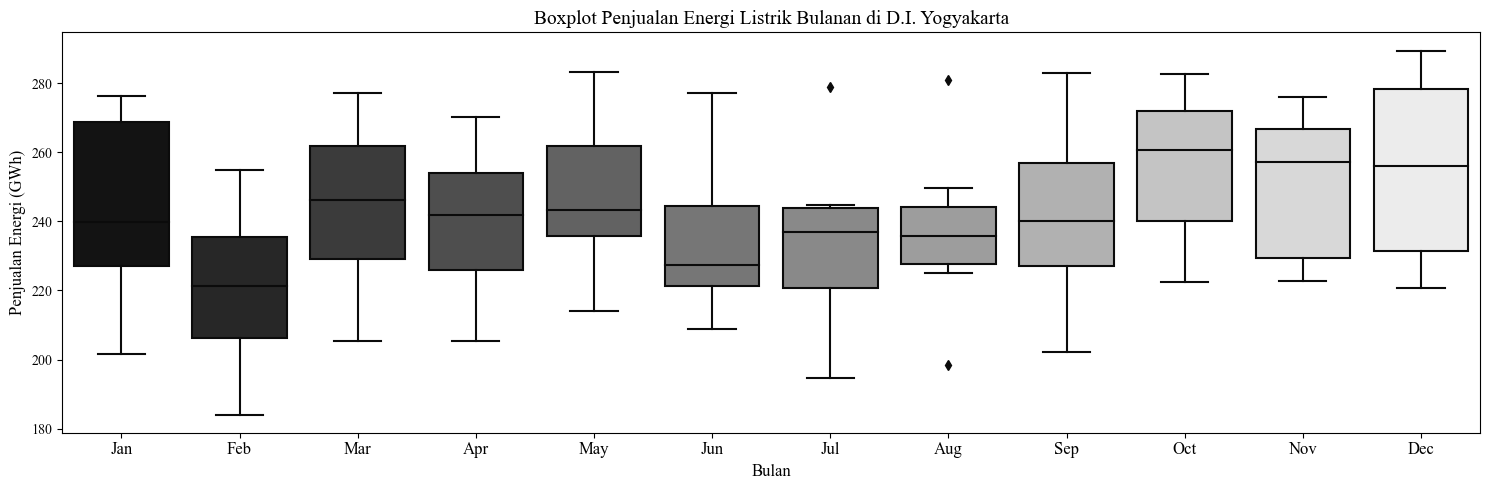

In [118]:
import seaborn as sns 
import matplotlib.pyplot as plt 
import calendar
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x='month', y='GWH_JUAL_FILTERED', data=df, ax=ax, palette='gray')

# Setting the month labels
months = [calendar.month_name[m][:3].title() for m in range(1, 13)]
ax.set_xticklabels(months, fontname='Times New Roman', fontsize=12)

ax.set_title('Boxplot Penjualan Energi Listrik Bulanan di D.I. Yogyakarta', fontname='Times New Roman', fontsize=14)
ax.set_xlabel('Bulan', fontname='Times New Roman', fontsize=12)
ax.set_ylabel('Penjualan Energi (GWh)', fontname='Times New Roman', fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()

In [119]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [120]:
df.fillna(0, inplace=True)
result = result = seasonal_decompose(df['GWH_JUAL_FILTERED'], model='multiplikatif', period=12)
df['trend'] = result.trend
#df['seasonal'] = result.seasonal
df = df[df['trend'].notnull()]  # Menghapus nilai NaN pada kolom 'trend'
df = df[df['trend'] != 0.0]

scaler = MinMaxScaler()
#df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
#df['resid'] = result.resid
df['GWH_JUAL_FILTERED'] = scaler.fit_transform(df[['GWH_JUAL_FILTERED']])
#df['seasonal'] = scaler.fit_transform(df[['seasonal']])
df['trend'] = scaler.fit_transform(df[['trend']])
df['month'] = scaler.fit_transform(df[['month']])

df.drop(columns='month', inplace=True)
df.fillna(0, inplace=True)

df.head(20)

,GWH_JUAL_FILTERED,trend
Date,,
2015-07-01,0.000000,0.000000
2015-08-01,0.042980,0.029802
2015-09-01,0.085961,0.055846
2015-10-01,0.313011,0.080097
2015-11-01,0.315661,0.105301
2015-12-01,0.293932,0.125961
2016-01-01,0.375499,0.147401
2016-02-01,0.137824,0.177437
2016-03-01,0.347813,0.208869


In [121]:
#df.Temp = df.Temp.transform(lambda x: (x - x.mean())/x.std())

In [122]:
#df = df.resample("W").mean()

<AxesSubplot: xlabel='Date'>

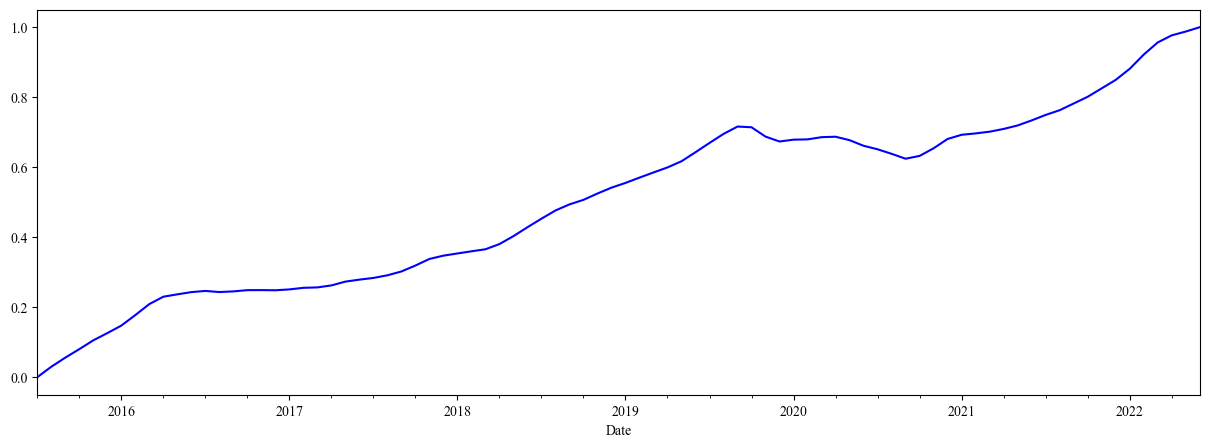

In [123]:
df.trend.plot(figsize=(15,5), color="b")


# Dataset Splitting 

In [124]:
ts_train, ts_test = train_test_split(df, test_size=0.2, shuffle=False)
ts_train.shape, ts_test.shape

((67, 2), (17, 2))

# Dataset & Dataloader

In [125]:
from torch.utils.data import DataLoader
from jcopdl.utils.dataloader import TimeSeriesDataset

In [140]:
seq_len = 6
bs = 2

train_set = TimeSeriesDataset(ts_train, "GWH_JUAL_FILTERED", seq_len)
trainloader = DataLoader(train_set, batch_size=bs)

test_set = TimeSeriesDataset(ts_test, "GWH_JUAL_FILTERED", seq_len)
testloader = DataLoader(test_set, batch_size=bs)

(N, S, F): (11, 6, 2)
Note: last 0 data excluded

(N, S, F): (2, 6, 2)
Note: last 4 data excluded



# Arsitektur & Config

In [141]:
from jcopdl.layers import linear_block

In [142]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        x, hidden = self.rnn(x, hidden)
        x = self.fc(x)
        return x, hidden

In [143]:
config = set_config({
    "input_size": train_set.n_feature,
    "output_size": 1,
    "hidden_size": 4,
    "num_layers": 8,
    "dropout": 0,
    "seq_len": train_set.n_seq
})

# Training Preparation --> MCOC

In [144]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = RNN(config.input_size, config.output_size, config.hidden_size, config.num_layers, config.dropout).to(device)
criterion = nn.MSELoss(reduction="mean")
optimizer = optim.AdamW(model.parameters(), lr=0.0005)
callback = Callback(model, config, outdir="model/LSTM")

# Training

In [145]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0 
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output, hidden = model(feature, None)
        loss = criterion(output, target)

        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        cost += loss.item() * feature.shape[0]
    cost = cost /len(dataset)
    return cost

Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 0.6261 | Test_cost  = 1.0321 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.5831 | Test_cost  = 0.9758 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.5414 | Test_cost  = 0.9204 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.5009 | Test_cost  = 0.8661 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.4615 | Test_cost  = 0.8128 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.4235 | Test_cost  = 0.7608 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.3869 | Test_cost  = 0.7103 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.3519 | Test_cost  = 0.6613 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.3185 | Test_cost  = 0.6140 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.2870 | Test_cost  = 0.5684 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 0.2572 | Test_cost  = 0.5247 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 0.2293 | Test_cost  = 0.4830 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 0.2034 | Test_cost  = 0.4436 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 0.1797 | Test_cost  = 0.4065 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 0.1581 | Test_cost  = 0.3719 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 0.1389 | Test_cost  = 0.3401 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 0.1218 | Test_cost  = 0.3110 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 0.1070 | Test_cost  = 0.2846 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 0.0942 | Test_cost  = 0.2609 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    20
Train_cost  = 0.0834 | Test_cost  = 0.2397 | 


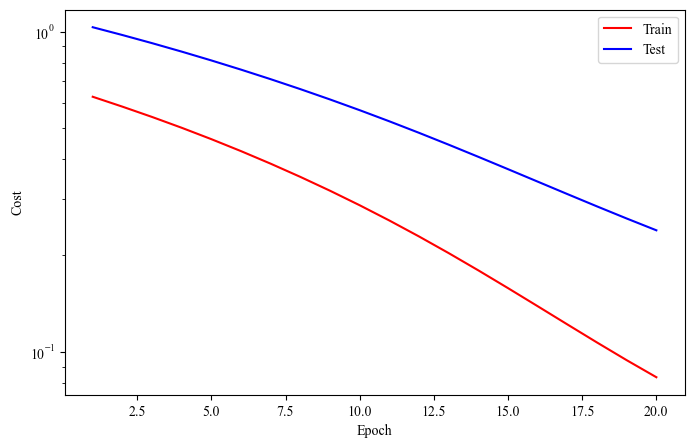

Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    21
Train_cost  = 0.0742 | Test_cost  = 0.2208 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    22
Train_cost  = 0.0666 | Test_cost  = 0.2042 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    23
Train_cost  = 0.0604 | Test_cost  = 0.1894 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    24
Train_cost  = 0.0553 | Test_cost  = 0.1765 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    25
Train_cost  = 0.0512 | Test_cost  = 0.1651 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    26
Train_cost  = 0.0478 | Test_cost  = 0.1551 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    27
Train_cost  = 0.0452 | Test_cost  = 0.1464 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    28
Train_cost  = 0.0431 | Test_cost  = 0.1388 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    29
Train_cost  = 0.0415 | Test_cost  = 0.1320 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    30
Train_cost  = 0.0403 | Test_cost  = 0.1262 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    31
Train_cost  = 0.0393 | Test_cost  = 0.1210 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    32
Train_cost  = 0.0386 | Test_cost  = 0.1165 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    33
Train_cost  = 0.0381 | Test_cost  = 0.1125 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    34
Train_cost  = 0.0377 | Test_cost  = 0.1091 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    35
Train_cost  = 0.0374 | Test_cost  = 0.1060 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    36
Train_cost  = 0.0372 | Test_cost  = 0.1033 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    37
Train_cost  = 0.0371 | Test_cost  = 0.1010 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    38
Train_cost  = 0.0370 | Test_cost  = 0.0989 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    39
Train_cost  = 0.0370 | Test_cost  = 0.0971 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    40
Train_cost  = 0.0369 | Test_cost  = 0.0955 | 


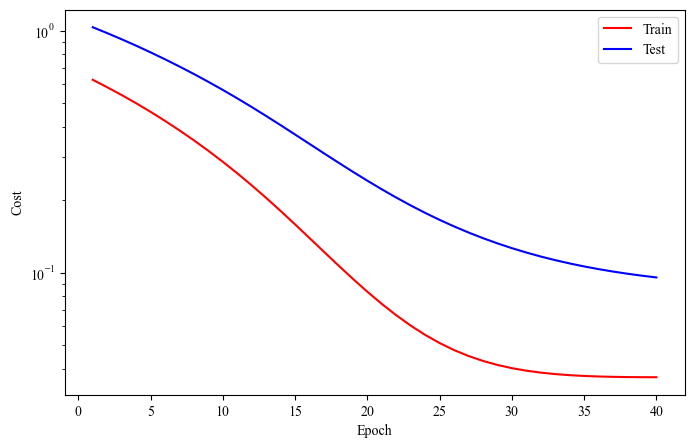

Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    41
Train_cost  = 0.0370 | Test_cost  = 0.0941 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    42
Train_cost  = 0.0370 | Test_cost  = 0.0928 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    43
Train_cost  = 0.0370 | Test_cost  = 0.0917 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    44
Train_cost  = 0.0370 | Test_cost  = 0.0908 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    45
Train_cost  = 0.0371 | Test_cost  = 0.0899 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    46
Train_cost  = 0.0371 | Test_cost  = 0.0892 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    47
Train_cost  = 0.0371 | Test_cost  = 0.0885 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    48
Train_cost  = 0.0371 | Test_cost  = 0.0879 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    49
Train_cost  = 0.0372 | Test_cost  = 0.0874 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    50
Train_cost  = 0.0372 | Test_cost  = 0.0869 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    51
Train_cost  = 0.0372 | Test_cost  = 0.0865 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    52
Train_cost  = 0.0372 | Test_cost  = 0.0862 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    53
Train_cost  = 0.0373 | Test_cost  = 0.0858 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    54
Train_cost  = 0.0373 | Test_cost  = 0.0856 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    55
Train_cost  = 0.0373 | Test_cost  = 0.0853 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    56
Train_cost  = 0.0373 | Test_cost  = 0.0851 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    57
Train_cost  = 0.0373 | Test_cost  = 0.0849 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    58
Train_cost  = 0.0373 | Test_cost  = 0.0847 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    59
Train_cost  = 0.0373 | Test_cost  = 0.0845 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    60
Train_cost  = 0.0373 | Test_cost  = 0.0844 | 


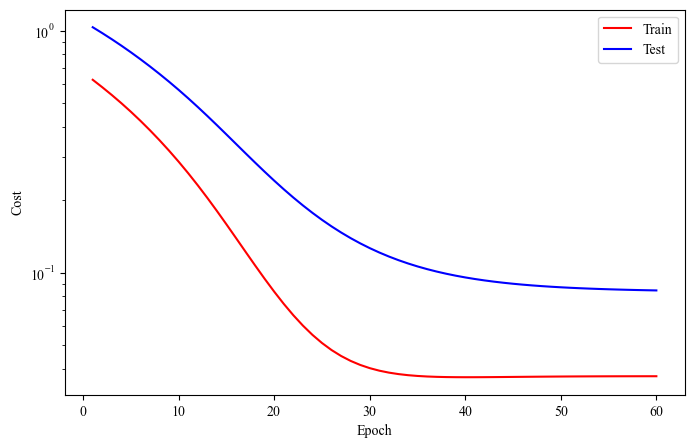

Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    61
Train_cost  = 0.0373 | Test_cost  = 0.0842 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    62
Train_cost  = 0.0373 | Test_cost  = 0.0841 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    63
Train_cost  = 0.0373 | Test_cost  = 0.0840 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    64
Train_cost  = 0.0373 | Test_cost  = 0.0839 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    65
Train_cost  = 0.0373 | Test_cost  = 0.0838 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    66
Train_cost  = 0.0373 | Test_cost  = 0.0837 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    67
Train_cost  = 0.0373 | Test_cost  = 0.0836 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    68
Train_cost  = 0.0373 | Test_cost  = 0.0835 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    69
Train_cost  = 0.0373 | Test_cost  = 0.0835 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    70
Train_cost  = 0.0373 | Test_cost  = 0.0834 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    71
Train_cost  = 0.0373 | Test_cost  = 0.0833 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    72
Train_cost  = 0.0373 | Test_cost  = 0.0833 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    73
Train_cost  = 0.0373 | Test_cost  = 0.0832 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    74
Train_cost  = 0.0372 | Test_cost  = 0.0832 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    75
Train_cost  = 0.0372 | Test_cost  = 0.0831 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    76
Train_cost  = 0.0372 | Test_cost  = 0.0830 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    77
Train_cost  = 0.0372 | Test_cost  = 0.0830 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    78
Train_cost  = 0.0372 | Test_cost  = 0.0829 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    79
Train_cost  = 0.0372 | Test_cost  = 0.0829 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    80
Train_cost  = 0.0372 | Test_cost  = 0.0828 | 


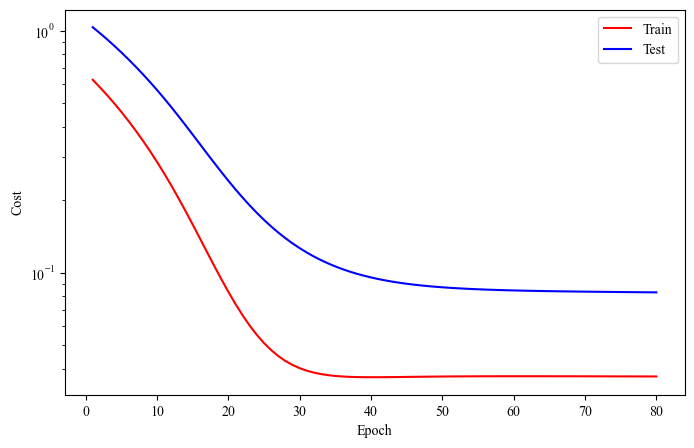

Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    81
Train_cost  = 0.0372 | Test_cost  = 0.0828 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    82
Train_cost  = 0.0372 | Test_cost  = 0.0827 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    83
Train_cost  = 0.0372 | Test_cost  = 0.0827 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    84
Train_cost  = 0.0372 | Test_cost  = 0.0827 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    85
Train_cost  = 0.0372 | Test_cost  = 0.0826 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    86
Train_cost  = 0.0372 | Test_cost  = 0.0826 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    87
Train_cost  = 0.0372 | Test_cost  = 0.0825 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    88
Train_cost  = 0.0372 | Test_cost  = 0.0825 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    89
Train_cost  = 0.0372 | Test_cost  = 0.0824 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    90
Train_cost  = 0.0372 | Test_cost  = 0.0824 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    91
Train_cost  = 0.0372 | Test_cost  = 0.0824 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    92
Train_cost  = 0.0372 | Test_cost  = 0.0823 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    93
Train_cost  = 0.0371 | Test_cost  = 0.0823 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    94
Train_cost  = 0.0371 | Test_cost  = 0.0822 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    95
Train_cost  = 0.0371 | Test_cost  = 0.0822 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    96
Train_cost  = 0.0371 | Test_cost  = 0.0822 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    97
Train_cost  = 0.0371 | Test_cost  = 0.0821 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    98
Train_cost  = 0.0371 | Test_cost  = 0.0821 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    99
Train_cost  = 0.0371 | Test_cost  = 0.0820 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   100
Train_cost  = 0.0371 | Test_cost  = 0.0820 | 


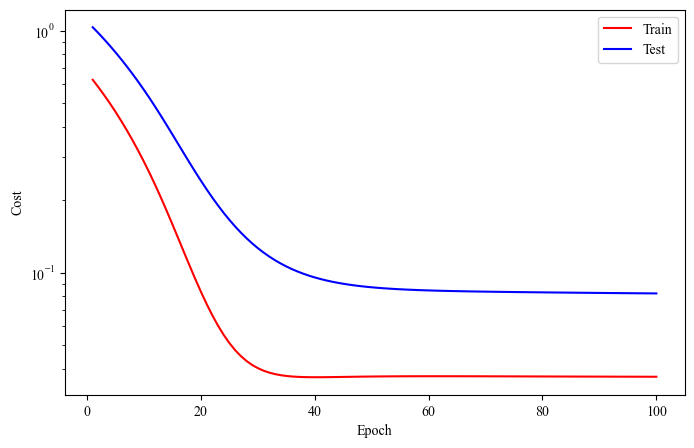

Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   101
Train_cost  = 0.0371 | Test_cost  = 0.0820 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   102
Train_cost  = 0.0371 | Test_cost  = 0.0819 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   103
Train_cost  = 0.0371 | Test_cost  = 0.0819 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   104
Train_cost  = 0.0371 | Test_cost  = 0.0819 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   105
Train_cost  = 0.0371 | Test_cost  = 0.0818 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   106
Train_cost  = 0.0371 | Test_cost  = 0.0818 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   107
Train_cost  = 0.0371 | Test_cost  = 0.0818 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   108
Train_cost  = 0.0371 | Test_cost  = 0.0817 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   109
Train_cost  = 0.0371 | Test_cost  = 0.0817 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   110
Train_cost  = 0.0371 | Test_cost  = 0.0817 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   111
Train_cost  = 0.0371 | Test_cost  = 0.0816 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   112
Train_cost  = 0.0371 | Test_cost  = 0.0816 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   113
Train_cost  = 0.0371 | Test_cost  = 0.0816 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   114
Train_cost  = 0.0371 | Test_cost  = 0.0815 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   115
Train_cost  = 0.0371 | Test_cost  = 0.0815 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   116
Train_cost  = 0.0371 | Test_cost  = 0.0815 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   117
Train_cost  = 0.0370 | Test_cost  = 0.0814 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   118
Train_cost  = 0.0370 | Test_cost  = 0.0814 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   119
Train_cost  = 0.0370 | Test_cost  = 0.0814 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   120
Train_cost  = 0.0370 | Test_cost  = 0.0813 | 


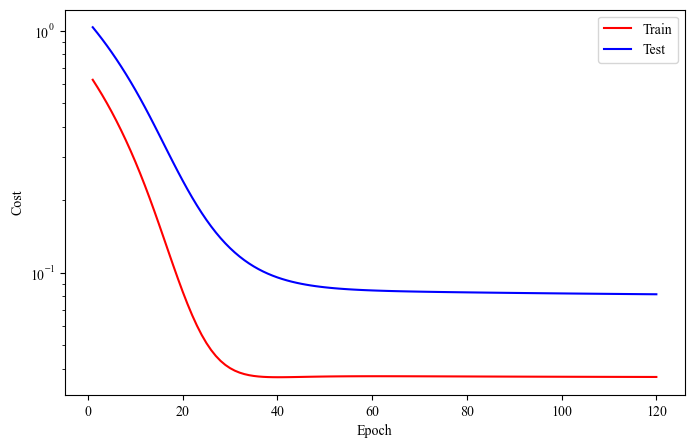

Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   121
Train_cost  = 0.0370 | Test_cost  = 0.0813 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   122
Train_cost  = 0.0370 | Test_cost  = 0.0813 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   123
Train_cost  = 0.0370 | Test_cost  = 0.0813 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   124
Train_cost  = 0.0370 | Test_cost  = 0.0812 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   125
Train_cost  = 0.0370 | Test_cost  = 0.0812 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   126
Train_cost  = 0.0370 | Test_cost  = 0.0812 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   127
Train_cost  = 0.0370 | Test_cost  = 0.0811 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   128
Train_cost  = 0.0370 | Test_cost  = 0.0811 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   129
Train_cost  = 0.0370 | Test_cost  = 0.0811 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   130
Train_cost  = 0.0370 | Test_cost  = 0.0811 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   131
Train_cost  = 0.0370 | Test_cost  = 0.0810 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   132
Train_cost  = 0.0370 | Test_cost  = 0.0810 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   133
Train_cost  = 0.0370 | Test_cost  = 0.0810 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   134
Train_cost  = 0.0370 | Test_cost  = 0.0810 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   135
Train_cost  = 0.0370 | Test_cost  = 0.0809 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   136
Train_cost  = 0.0370 | Test_cost  = 0.0809 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   137
Train_cost  = 0.0370 | Test_cost  = 0.0809 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   138
Train_cost  = 0.0370 | Test_cost  = 0.0809 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   139
Train_cost  = 0.0370 | Test_cost  = 0.0808 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   140
Train_cost  = 0.0370 | Test_cost  = 0.0808 | 


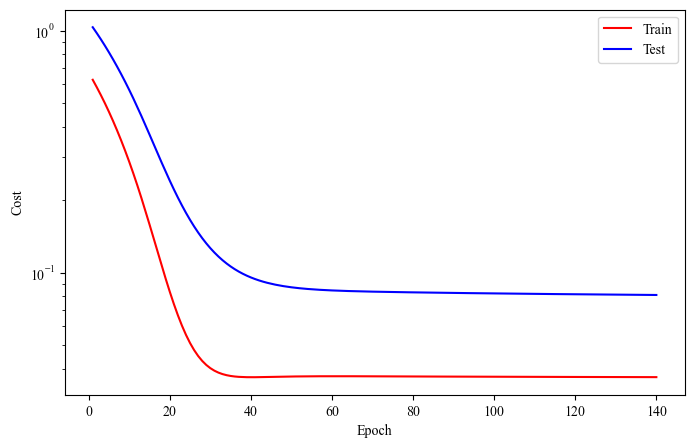

Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   141
Train_cost  = 0.0370 | Test_cost  = 0.0808 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   142
Train_cost  = 0.0370 | Test_cost  = 0.0808 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   143
Train_cost  = 0.0370 | Test_cost  = 0.0807 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   144
Train_cost  = 0.0370 | Test_cost  = 0.0807 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   145
Train_cost  = 0.0370 | Test_cost  = 0.0807 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   146
Train_cost  = 0.0370 | Test_cost  = 0.0807 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   147
Train_cost  = 0.0370 | Test_cost  = 0.0806 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   148
Train_cost  = 0.0370 | Test_cost  = 0.0806 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   149
Train_cost  = 0.0369 | Test_cost  = 0.0806 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   150
Train_cost  = 0.0369 | Test_cost  = 0.0806 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   151
Train_cost  = 0.0369 | Test_cost  = 0.0805 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   152
Train_cost  = 0.0369 | Test_cost  = 0.0805 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   153
Train_cost  = 0.0369 | Test_cost  = 0.0805 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   154
Train_cost  = 0.0369 | Test_cost  = 0.0805 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   155
Train_cost  = 0.0369 | Test_cost  = 0.0804 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   156
Train_cost  = 0.0369 | Test_cost  = 0.0804 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   157
Train_cost  = 0.0369 | Test_cost  = 0.0804 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   158
Train_cost  = 0.0369 | Test_cost  = 0.0804 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   159
Train_cost  = 0.0369 | Test_cost  = 0.0803 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   160
Train_cost  = 0.0369 | Test_cost  = 0.0803 | 


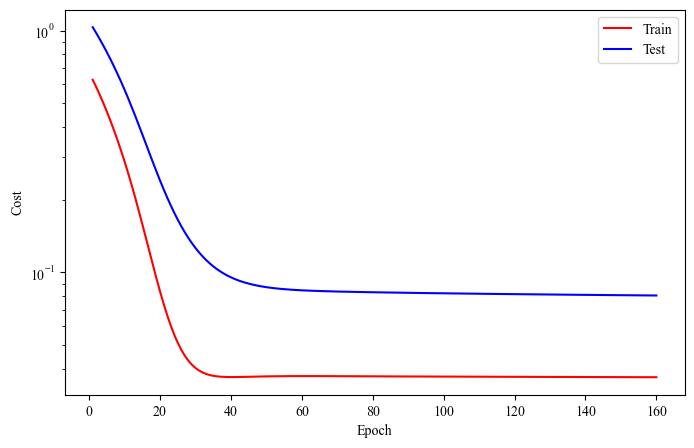

Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   161
Train_cost  = 0.0369 | Test_cost  = 0.0803 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   162
Train_cost  = 0.0369 | Test_cost  = 0.0803 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   163
Train_cost  = 0.0369 | Test_cost  = 0.0803 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   164
Train_cost  = 0.0369 | Test_cost  = 0.0802 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   165
Train_cost  = 0.0369 | Test_cost  = 0.0802 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   166
Train_cost  = 0.0369 | Test_cost  = 0.0802 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   167
Train_cost  = 0.0368 | Test_cost  = 0.0801 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   168
Train_cost  = 0.0368 | Test_cost  = 0.0801 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   169
Train_cost  = 0.0368 | Test_cost  = 0.0801 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   170
Train_cost  = 0.0368 | Test_cost  = 0.0801 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   171
Train_cost  = 0.0368 | Test_cost  = 0.0800 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   172
Train_cost  = 0.0368 | Test_cost  = 0.0800 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   173
Train_cost  = 0.0368 | Test_cost  = 0.0800 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   174
Train_cost  = 0.0368 | Test_cost  = 0.0799 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   175
Train_cost  = 0.0367 | Test_cost  = 0.0799 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   176
Train_cost  = 0.0367 | Test_cost  = 0.0799 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   177
Train_cost  = 0.0367 | Test_cost  = 0.0798 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   178
Train_cost  = 0.0367 | Test_cost  = 0.0798 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   179
Train_cost  = 0.0366 | Test_cost  = 0.0797 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   180
Train_cost  = 0.0366 | Test_cost  = 0.0797 | 


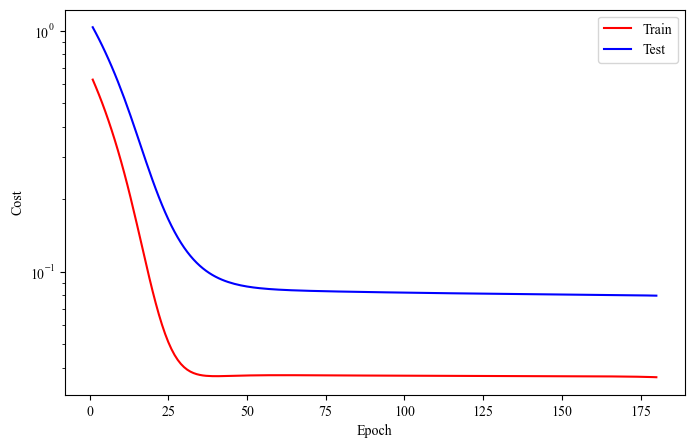

Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   181
Train_cost  = 0.0365 | Test_cost  = 0.0796 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   182
Train_cost  = 0.0365 | Test_cost  = 0.0795 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   183
Train_cost  = 0.0364 | Test_cost  = 0.0795 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   184
Train_cost  = 0.0363 | Test_cost  = 0.0794 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   185
Train_cost  = 0.0363 | Test_cost  = 0.0793 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   186
Train_cost  = 0.0361 | Test_cost  = 0.0792 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   187
Train_cost  = 0.0360 | Test_cost  = 0.0791 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   188
Train_cost  = 0.0359 | Test_cost  = 0.0790 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   189
Train_cost  = 0.0357 | Test_cost  = 0.0788 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   190
Train_cost  = 0.0354 | Test_cost  = 0.0786 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   191
Train_cost  = 0.0352 | Test_cost  = 0.0784 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   192
Train_cost  = 0.0349 | Test_cost  = 0.0782 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   193
Train_cost  = 0.0345 | Test_cost  = 0.0779 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   194
Train_cost  = 0.0341 | Test_cost  = 0.0776 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   195
Train_cost  = 0.0337 | Test_cost  = 0.0772 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   196
Train_cost  = 0.0332 | Test_cost  = 0.0768 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   197
Train_cost  = 0.0327 | Test_cost  = 0.0763 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   198
Train_cost  = 0.0322 | Test_cost  = 0.0757 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   199
Train_cost  = 0.0317 | Test_cost  = 0.0751 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   200
Train_cost  = 0.0312 | Test_cost  = 0.0744 | 


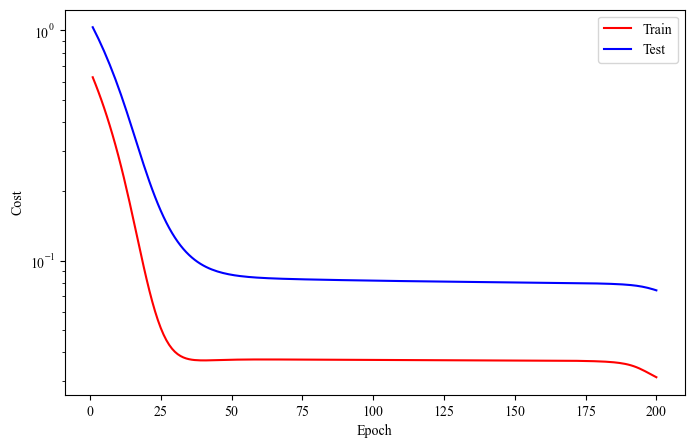

Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   201
Train_cost  = 0.0308 | Test_cost  = 0.0737 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   202
Train_cost  = 0.0303 | Test_cost  = 0.0730 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   203
Train_cost  = 0.0299 | Test_cost  = 0.0722 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   204
Train_cost  = 0.0294 | Test_cost  = 0.0714 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   205
Train_cost  = 0.0289 | Test_cost  = 0.0706 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   206
Train_cost  = 0.0285 | Test_cost  = 0.0698 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   207
Train_cost  = 0.0279 | Test_cost  = 0.0689 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   208
Train_cost  = 0.0274 | Test_cost  = 0.0681 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   209
Train_cost  = 0.0267 | Test_cost  = 0.0672 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   210
Train_cost  = 0.0259 | Test_cost  = 0.0665 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   211
Train_cost  = 0.0252 | Test_cost  = 0.0658 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   212
Train_cost  = 0.0243 | Test_cost  = 0.0651 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   213
Train_cost  = 0.0234 | Test_cost  = 0.0643 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   214
Train_cost  = 0.0223 | Test_cost  = 0.0634 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   215
Train_cost  = 0.0212 | Test_cost  = 0.0623 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   216
Train_cost  = 0.0200 | Test_cost  = 0.0609 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   217
Train_cost  = 0.0190 | Test_cost  = 0.0593 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   218
Train_cost  = 0.0180 | Test_cost  = 0.0575 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   219
Train_cost  = 0.0173 | Test_cost  = 0.0556 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   220
Train_cost  = 0.0167 | Test_cost  = 0.0537 | 


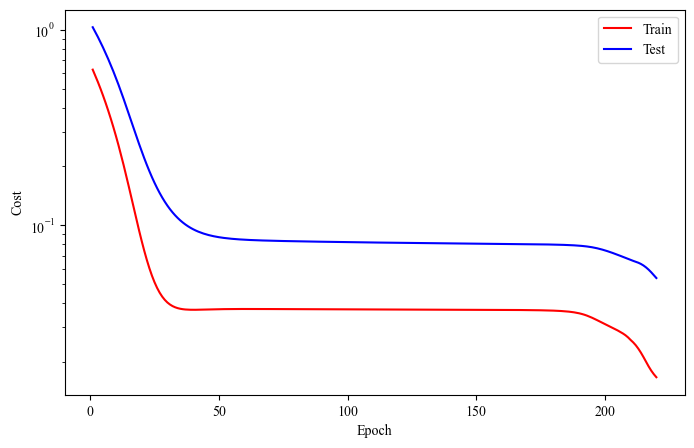

Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   221
Train_cost  = 0.0162 | Test_cost  = 0.0519 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   222
Train_cost  = 0.0157 | Test_cost  = 0.0502 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   223
Train_cost  = 0.0153 | Test_cost  = 0.0487 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   224
Train_cost  = 0.0150 | Test_cost  = 0.0473 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   225
Train_cost  = 0.0146 | Test_cost  = 0.0462 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   226
Train_cost  = 0.0143 | Test_cost  = 0.0452 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   227
Train_cost  = 0.0140 | Test_cost  = 0.0443 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   228
Train_cost  = 0.0137 | Test_cost  = 0.0434 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   229
Train_cost  = 0.0135 | Test_cost  = 0.0427 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   230
Train_cost  = 0.0135 | Test_cost  = 0.0419 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   231
Train_cost  = 0.0133 | Test_cost  = 0.0408 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   232
Train_cost  = 0.0130 | Test_cost  = 0.0399 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   233
Train_cost  = 0.0135 | Test_cost  = 0.0398 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   234
Train_cost  = 0.0132 | Test_cost  = 0.0396 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   235
Train_cost  = 0.0132 | Test_cost  = 0.0390 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   236
Train_cost  = 0.0131 | Test_cost  = 0.0383 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   237
Train_cost  = 0.0130 | Test_cost  = 0.0375 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   238
Train_cost  = 0.0129 | Test_cost  = 0.0368 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   239
Train_cost  = 0.0129 | Test_cost  = 0.0363 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   240
Train_cost  = 0.0128 | Test_cost  = 0.0358 | 


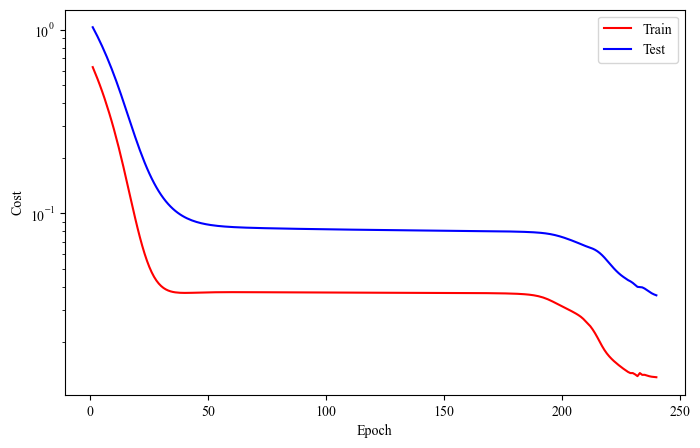

Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   241
Train_cost  = 0.0128 | Test_cost  = 0.0355 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   242
Train_cost  = 0.0127 | Test_cost  = 0.0353 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   243
Train_cost  = 0.0127 | Test_cost  = 0.0350 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   244
Train_cost  = 0.0126 | Test_cost  = 0.0348 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   245
Train_cost  = 0.0126 | Test_cost  = 0.0346 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   246
Train_cost  = 0.0125 | Test_cost  = 0.0344 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   247
Train_cost  = 0.0124 | Test_cost  = 0.0342 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   248
Train_cost  = 0.0124 | Test_cost  = 0.0341 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   249
Train_cost  = 0.0123 | Test_cost  = 0.0339 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   250
Train_cost  = 0.0122 | Test_cost  = 0.0338 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   251
Train_cost  = 0.0121 | Test_cost  = 0.0337 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   252
Train_cost  = 0.0120 | Test_cost  = 0.0337 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   253
Train_cost  = 0.0120 | Test_cost  = 0.0338 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0337


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   254
Train_cost  = 0.0120 | Test_cost  = 0.0337 | 
==> EarlyStop patience =  2 | Best test_cost: 0.0337


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   255
Train_cost  = 0.0119 | Test_cost  = 0.0337 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   256
Train_cost  = 0.0119 | Test_cost  = 0.0336 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   257
Train_cost  = 0.0119 | Test_cost  = 0.0335 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   258
Train_cost  = 0.0118 | Test_cost  = 0.0333 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   259
Train_cost  = 0.0119 | Test_cost  = 0.0333 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   260
Train_cost  = 0.0119 | Test_cost  = 0.0332 | 


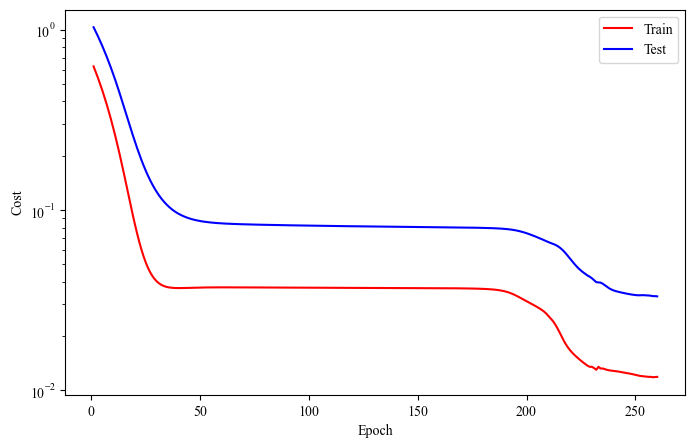

Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   261
Train_cost  = 0.0118 | Test_cost  = 0.0330 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   262
Train_cost  = 0.0118 | Test_cost  = 0.0329 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   263
Train_cost  = 0.0118 | Test_cost  = 0.0330 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0329


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   264
Train_cost  = 0.0118 | Test_cost  = 0.0329 | 
==> EarlyStop patience =  2 | Best test_cost: 0.0329


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   265
Train_cost  = 0.0118 | Test_cost  = 0.0328 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   266
Train_cost  = 0.0117 | Test_cost  = 0.0328 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   267
Train_cost  = 0.0117 | Test_cost  = 0.0328 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0328


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   268
Train_cost  = 0.0117 | Test_cost  = 0.0327 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   269
Train_cost  = 0.0117 | Test_cost  = 0.0327 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   270
Train_cost  = 0.0117 | Test_cost  = 0.0327 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   271
Train_cost  = 0.0117 | Test_cost  = 0.0326 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   272
Train_cost  = 0.0117 | Test_cost  = 0.0326 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   273
Train_cost  = 0.0117 | Test_cost  = 0.0325 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   274
Train_cost  = 0.0116 | Test_cost  = 0.0325 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   275
Train_cost  = 0.0116 | Test_cost  = 0.0325 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   276
Train_cost  = 0.0116 | Test_cost  = 0.0324 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   277
Train_cost  = 0.0116 | Test_cost  = 0.0324 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   278
Train_cost  = 0.0116 | Test_cost  = 0.0324 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   279
Train_cost  = 0.0116 | Test_cost  = 0.0323 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   280
Train_cost  = 0.0116 | Test_cost  = 0.0323 | 


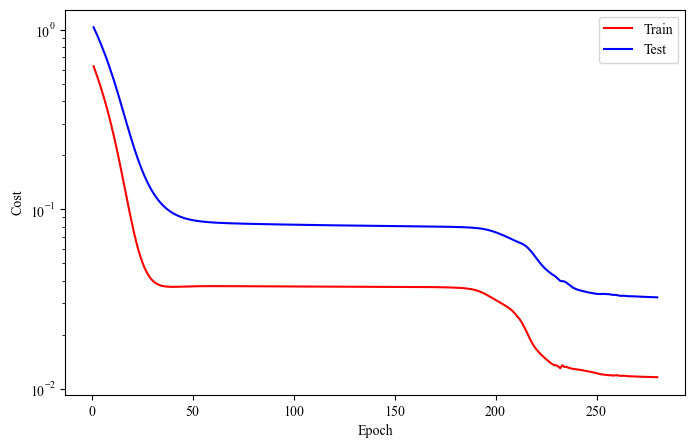

Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   281
Train_cost  = 0.0116 | Test_cost  = 0.0323 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   282
Train_cost  = 0.0116 | Test_cost  = 0.0322 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   283
Train_cost  = 0.0116 | Test_cost  = 0.0322 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   284
Train_cost  = 0.0116 | Test_cost  = 0.0322 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   285
Train_cost  = 0.0116 | Test_cost  = 0.0322 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   286
Train_cost  = 0.0115 | Test_cost  = 0.0321 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   287
Train_cost  = 0.0115 | Test_cost  = 0.0321 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   288
Train_cost  = 0.0115 | Test_cost  = 0.0321 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   289
Train_cost  = 0.0115 | Test_cost  = 0.0321 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   290
Train_cost  = 0.0115 | Test_cost  = 0.0321 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   291
Train_cost  = 0.0115 | Test_cost  = 0.0320 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   292
Train_cost  = 0.0115 | Test_cost  = 0.0320 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   293
Train_cost  = 0.0115 | Test_cost  = 0.0320 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   294
Train_cost  = 0.0115 | Test_cost  = 0.0320 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   295
Train_cost  = 0.0115 | Test_cost  = 0.0320 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   296
Train_cost  = 0.0115 | Test_cost  = 0.0319 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   297
Train_cost  = 0.0115 | Test_cost  = 0.0319 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   298
Train_cost  = 0.0115 | Test_cost  = 0.0319 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   299
Train_cost  = 0.0114 | Test_cost  = 0.0319 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   300
Train_cost  = 0.0114 | Test_cost  = 0.0319 | 


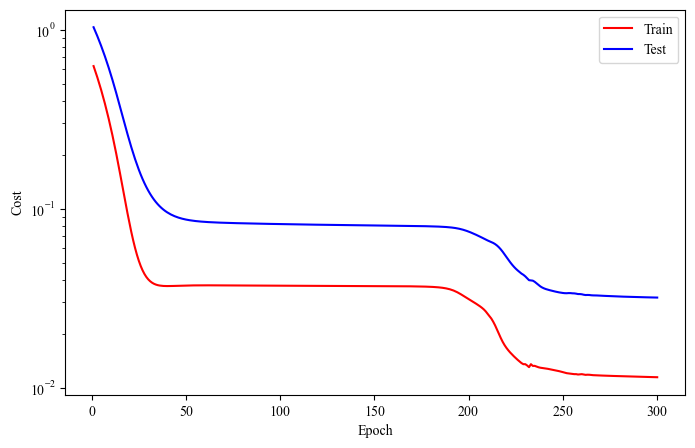

Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   301
Train_cost  = 0.0114 | Test_cost  = 0.0318 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   302
Train_cost  = 0.0114 | Test_cost  = 0.0318 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   303
Train_cost  = 0.0114 | Test_cost  = 0.0318 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   304
Train_cost  = 0.0114 | Test_cost  = 0.0318 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   305
Train_cost  = 0.0114 | Test_cost  = 0.0318 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   306
Train_cost  = 0.0114 | Test_cost  = 0.0318 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   307
Train_cost  = 0.0114 | Test_cost  = 0.0317 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   308
Train_cost  = 0.0114 | Test_cost  = 0.0317 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   309
Train_cost  = 0.0114 | Test_cost  = 0.0317 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   310
Train_cost  = 0.0114 | Test_cost  = 0.0317 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   311
Train_cost  = 0.0114 | Test_cost  = 0.0317 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   312
Train_cost  = 0.0114 | Test_cost  = 0.0317 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   313
Train_cost  = 0.0113 | Test_cost  = 0.0317 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   314
Train_cost  = 0.0113 | Test_cost  = 0.0316 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   315
Train_cost  = 0.0113 | Test_cost  = 0.0316 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   316
Train_cost  = 0.0113 | Test_cost  = 0.0316 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   317
Train_cost  = 0.0113 | Test_cost  = 0.0316 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   318
Train_cost  = 0.0113 | Test_cost  = 0.0316 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   319
Train_cost  = 0.0113 | Test_cost  = 0.0316 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   320
Train_cost  = 0.0113 | Test_cost  = 0.0315 | 


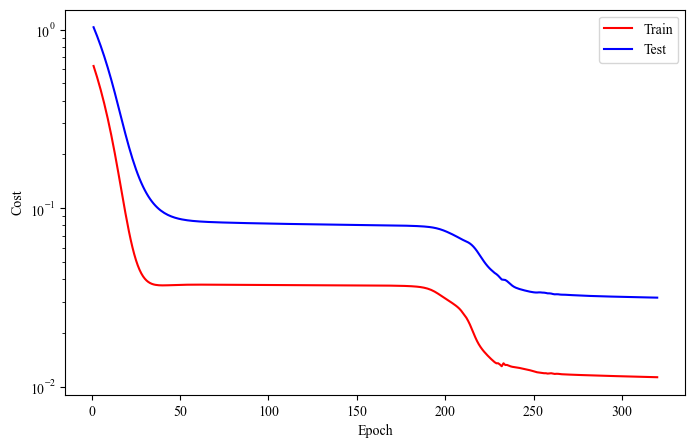

Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   321
Train_cost  = 0.0113 | Test_cost  = 0.0315 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   322
Train_cost  = 0.0113 | Test_cost  = 0.0315 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   323
Train_cost  = 0.0113 | Test_cost  = 0.0315 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   324
Train_cost  = 0.0113 | Test_cost  = 0.0315 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   325
Train_cost  = 0.0113 | Test_cost  = 0.0315 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   326
Train_cost  = 0.0113 | Test_cost  = 0.0314 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   327
Train_cost  = 0.0113 | Test_cost  = 0.0314 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   328
Train_cost  = 0.0113 | Test_cost  = 0.0314 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   329
Train_cost  = 0.0112 | Test_cost  = 0.0314 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   330
Train_cost  = 0.0112 | Test_cost  = 0.0314 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   331
Train_cost  = 0.0112 | Test_cost  = 0.0314 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   332
Train_cost  = 0.0112 | Test_cost  = 0.0314 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   333
Train_cost  = 0.0112 | Test_cost  = 0.0313 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   334
Train_cost  = 0.0112 | Test_cost  = 0.0313 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   335
Train_cost  = 0.0112 | Test_cost  = 0.0313 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   336
Train_cost  = 0.0112 | Test_cost  = 0.0313 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   337
Train_cost  = 0.0112 | Test_cost  = 0.0313 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   338
Train_cost  = 0.0112 | Test_cost  = 0.0313 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   339
Train_cost  = 0.0112 | Test_cost  = 0.0312 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   340
Train_cost  = 0.0112 | Test_cost  = 0.0312 | 


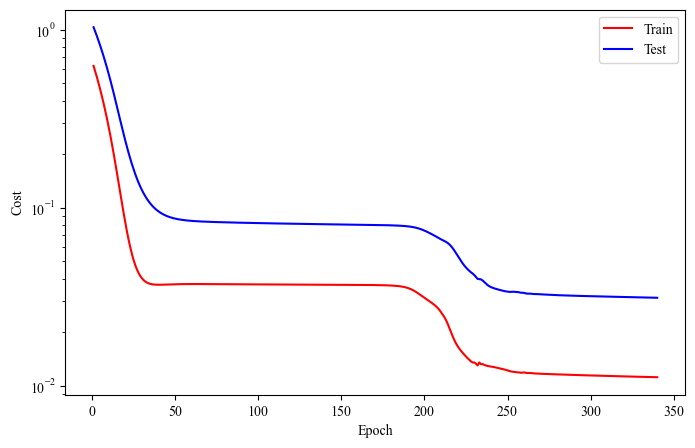

Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   341
Train_cost  = 0.0112 | Test_cost  = 0.0312 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   342
Train_cost  = 0.0112 | Test_cost  = 0.0312 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   343
Train_cost  = 0.0112 | Test_cost  = 0.0312 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   344
Train_cost  = 0.0112 | Test_cost  = 0.0312 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   345
Train_cost  = 0.0112 | Test_cost  = 0.0311 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   346
Train_cost  = 0.0111 | Test_cost  = 0.0311 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   347
Train_cost  = 0.0111 | Test_cost  = 0.0311 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   348
Train_cost  = 0.0111 | Test_cost  = 0.0311 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   349
Train_cost  = 0.0111 | Test_cost  = 0.0311 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   350
Train_cost  = 0.0111 | Test_cost  = 0.0311 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   351
Train_cost  = 0.0111 | Test_cost  = 0.0311 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   352
Train_cost  = 0.0111 | Test_cost  = 0.0310 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   353
Train_cost  = 0.0111 | Test_cost  = 0.0310 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   354
Train_cost  = 0.0111 | Test_cost  = 0.0310 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   355
Train_cost  = 0.0111 | Test_cost  = 0.0310 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   356
Train_cost  = 0.0111 | Test_cost  = 0.0310 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   357
Train_cost  = 0.0111 | Test_cost  = 0.0310 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   358
Train_cost  = 0.0111 | Test_cost  = 0.0309 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   359
Train_cost  = 0.0111 | Test_cost  = 0.0309 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   360
Train_cost  = 0.0111 | Test_cost  = 0.0309 | 


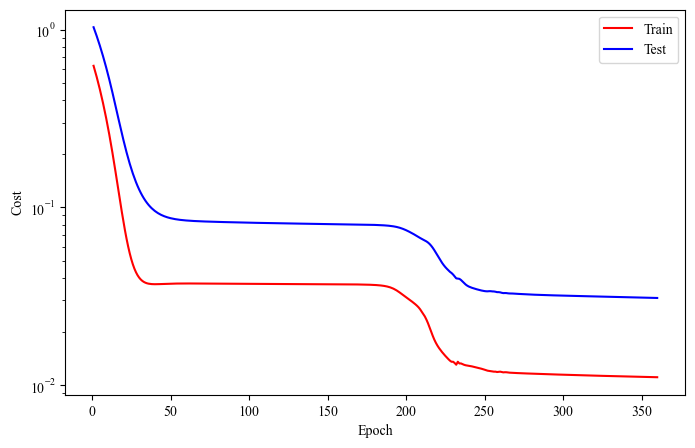

Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   361
Train_cost  = 0.0111 | Test_cost  = 0.0309 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   362
Train_cost  = 0.0111 | Test_cost  = 0.0309 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   363
Train_cost  = 0.0111 | Test_cost  = 0.0309 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   364
Train_cost  = 0.0110 | Test_cost  = 0.0308 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   365
Train_cost  = 0.0110 | Test_cost  = 0.0308 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   366
Train_cost  = 0.0110 | Test_cost  = 0.0308 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   367
Train_cost  = 0.0110 | Test_cost  = 0.0308 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   368
Train_cost  = 0.0110 | Test_cost  = 0.0308 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   369
Train_cost  = 0.0110 | Test_cost  = 0.0308 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   370
Train_cost  = 0.0110 | Test_cost  = 0.0308 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   371
Train_cost  = 0.0110 | Test_cost  = 0.0307 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   372
Train_cost  = 0.0110 | Test_cost  = 0.0307 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   373
Train_cost  = 0.0110 | Test_cost  = 0.0307 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   374
Train_cost  = 0.0110 | Test_cost  = 0.0307 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   375
Train_cost  = 0.0110 | Test_cost  = 0.0307 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   376
Train_cost  = 0.0110 | Test_cost  = 0.0307 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   377
Train_cost  = 0.0110 | Test_cost  = 0.0306 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   378
Train_cost  = 0.0110 | Test_cost  = 0.0306 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   379
Train_cost  = 0.0110 | Test_cost  = 0.0306 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   380
Train_cost  = 0.0110 | Test_cost  = 0.0306 | 


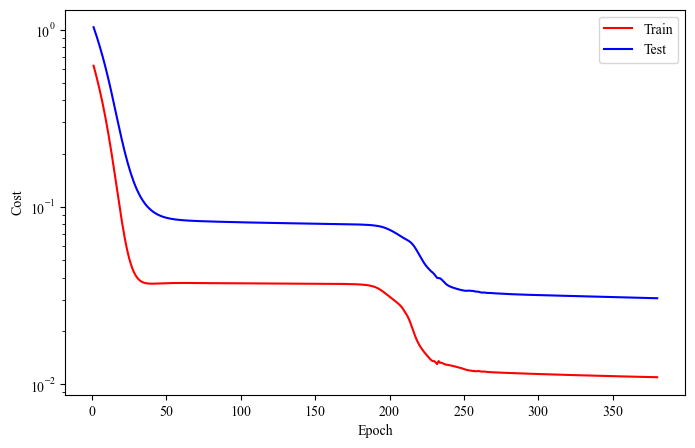

Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   381
Train_cost  = 0.0110 | Test_cost  = 0.0306 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   382
Train_cost  = 0.0110 | Test_cost  = 0.0306 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   383
Train_cost  = 0.0110 | Test_cost  = 0.0305 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   384
Train_cost  = 0.0110 | Test_cost  = 0.0305 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   385
Train_cost  = 0.0109 | Test_cost  = 0.0305 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   386
Train_cost  = 0.0109 | Test_cost  = 0.0305 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   387
Train_cost  = 0.0109 | Test_cost  = 0.0305 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   388
Train_cost  = 0.0109 | Test_cost  = 0.0305 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   389
Train_cost  = 0.0109 | Test_cost  = 0.0304 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   390
Train_cost  = 0.0109 | Test_cost  = 0.0304 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   391
Train_cost  = 0.0109 | Test_cost  = 0.0304 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   392
Train_cost  = 0.0109 | Test_cost  = 0.0304 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   393
Train_cost  = 0.0109 | Test_cost  = 0.0304 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   394
Train_cost  = 0.0109 | Test_cost  = 0.0304 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   395
Train_cost  = 0.0109 | Test_cost  = 0.0303 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   396
Train_cost  = 0.0109 | Test_cost  = 0.0303 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   397
Train_cost  = 0.0109 | Test_cost  = 0.0303 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   398
Train_cost  = 0.0109 | Test_cost  = 0.0303 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   399
Train_cost  = 0.0109 | Test_cost  = 0.0303 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   400
Train_cost  = 0.0109 | Test_cost  = 0.0303 | 


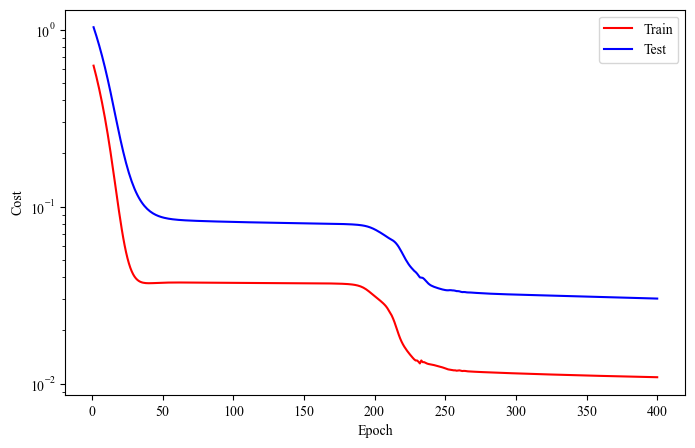

Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   401
Train_cost  = 0.0109 | Test_cost  = 0.0302 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   402
Train_cost  = 0.0109 | Test_cost  = 0.0302 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   403
Train_cost  = 0.0109 | Test_cost  = 0.0302 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   404
Train_cost  = 0.0109 | Test_cost  = 0.0302 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   405
Train_cost  = 0.0109 | Test_cost  = 0.0302 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   406
Train_cost  = 0.0109 | Test_cost  = 0.0302 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   407
Train_cost  = 0.0108 | Test_cost  = 0.0301 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   408
Train_cost  = 0.0108 | Test_cost  = 0.0301 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   409
Train_cost  = 0.0108 | Test_cost  = 0.0301 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   410
Train_cost  = 0.0108 | Test_cost  = 0.0301 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   411
Train_cost  = 0.0108 | Test_cost  = 0.0301 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   412
Train_cost  = 0.0108 | Test_cost  = 0.0301 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   413
Train_cost  = 0.0108 | Test_cost  = 0.0300 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   414
Train_cost  = 0.0108 | Test_cost  = 0.0300 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   415
Train_cost  = 0.0108 | Test_cost  = 0.0300 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   416
Train_cost  = 0.0108 | Test_cost  = 0.0300 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   417
Train_cost  = 0.0108 | Test_cost  = 0.0300 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   418
Train_cost  = 0.0108 | Test_cost  = 0.0300 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   419
Train_cost  = 0.0108 | Test_cost  = 0.0299 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   420
Train_cost  = 0.0108 | Test_cost  = 0.0299 | 


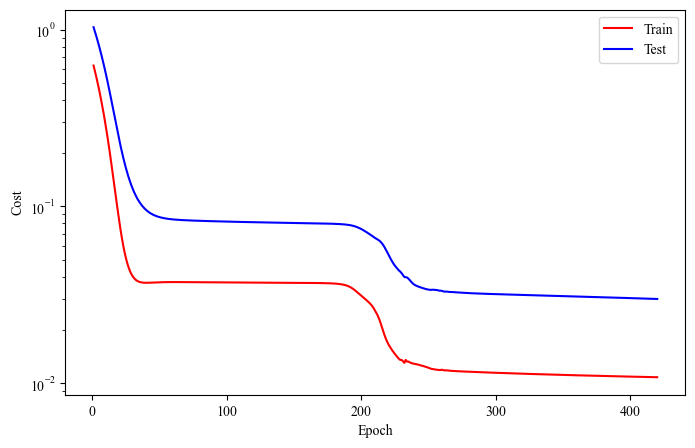

Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   421
Train_cost  = 0.0108 | Test_cost  = 0.0299 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   422
Train_cost  = 0.0108 | Test_cost  = 0.0299 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   423
Train_cost  = 0.0108 | Test_cost  = 0.0299 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   424
Train_cost  = 0.0108 | Test_cost  = 0.0299 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   425
Train_cost  = 0.0108 | Test_cost  = 0.0298 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   426
Train_cost  = 0.0108 | Test_cost  = 0.0298 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   427
Train_cost  = 0.0108 | Test_cost  = 0.0298 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   428
Train_cost  = 0.0108 | Test_cost  = 0.0298 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   429
Train_cost  = 0.0108 | Test_cost  = 0.0298 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   430
Train_cost  = 0.0108 | Test_cost  = 0.0298 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   431
Train_cost  = 0.0108 | Test_cost  = 0.0297 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   432
Train_cost  = 0.0107 | Test_cost  = 0.0297 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   433
Train_cost  = 0.0107 | Test_cost  = 0.0297 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   434
Train_cost  = 0.0107 | Test_cost  = 0.0297 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   435
Train_cost  = 0.0107 | Test_cost  = 0.0297 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   436
Train_cost  = 0.0107 | Test_cost  = 0.0297 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   437
Train_cost  = 0.0107 | Test_cost  = 0.0296 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   438
Train_cost  = 0.0107 | Test_cost  = 0.0296 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   439
Train_cost  = 0.0107 | Test_cost  = 0.0296 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   440
Train_cost  = 0.0107 | Test_cost  = 0.0296 | 


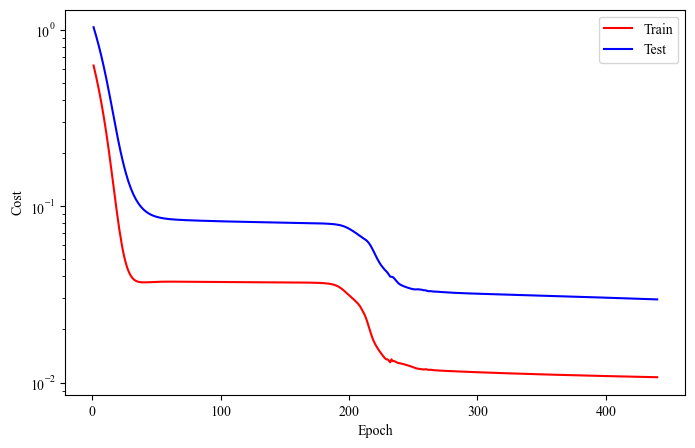

Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   441
Train_cost  = 0.0107 | Test_cost  = 0.0296 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   442
Train_cost  = 0.0107 | Test_cost  = 0.0295 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   443
Train_cost  = 0.0107 | Test_cost  = 0.0295 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   444
Train_cost  = 0.0107 | Test_cost  = 0.0295 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   445
Train_cost  = 0.0107 | Test_cost  = 0.0295 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   446
Train_cost  = 0.0107 | Test_cost  = 0.0295 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   447
Train_cost  = 0.0107 | Test_cost  = 0.0295 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   448
Train_cost  = 0.0107 | Test_cost  = 0.0294 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   449
Train_cost  = 0.0107 | Test_cost  = 0.0294 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   450
Train_cost  = 0.0107 | Test_cost  = 0.0294 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   451
Train_cost  = 0.0107 | Test_cost  = 0.0294 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   452
Train_cost  = 0.0107 | Test_cost  = 0.0294 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   453
Train_cost  = 0.0107 | Test_cost  = 0.0294 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   454
Train_cost  = 0.0107 | Test_cost  = 0.0293 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   455
Train_cost  = 0.0107 | Test_cost  = 0.0293 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   456
Train_cost  = 0.0107 | Test_cost  = 0.0293 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   457
Train_cost  = 0.0107 | Test_cost  = 0.0293 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   458
Train_cost  = 0.0106 | Test_cost  = 0.0293 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   459
Train_cost  = 0.0106 | Test_cost  = 0.0292 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   460
Train_cost  = 0.0106 | Test_cost  = 0.0292 | 


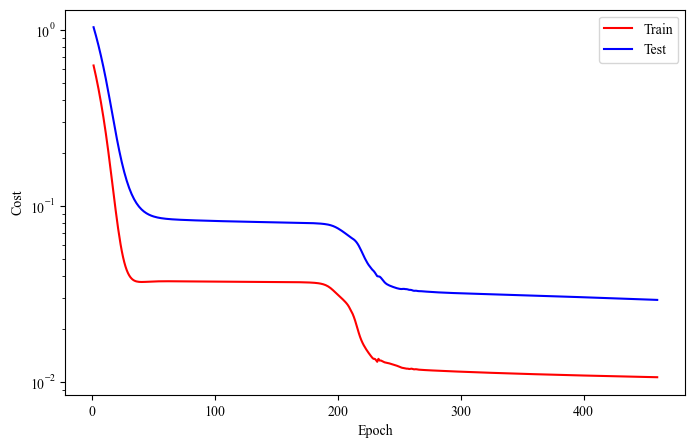

Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   461
Train_cost  = 0.0106 | Test_cost  = 0.0292 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   462
Train_cost  = 0.0106 | Test_cost  = 0.0292 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   463
Train_cost  = 0.0106 | Test_cost  = 0.0292 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   464
Train_cost  = 0.0106 | Test_cost  = 0.0292 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   465
Train_cost  = 0.0106 | Test_cost  = 0.0291 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   466
Train_cost  = 0.0106 | Test_cost  = 0.0291 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   467
Train_cost  = 0.0106 | Test_cost  = 0.0291 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   468
Train_cost  = 0.0106 | Test_cost  = 0.0291 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   469
Train_cost  = 0.0106 | Test_cost  = 0.0291 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   470
Train_cost  = 0.0106 | Test_cost  = 0.0290 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   471
Train_cost  = 0.0106 | Test_cost  = 0.0290 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   472
Train_cost  = 0.0106 | Test_cost  = 0.0290 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   473
Train_cost  = 0.0106 | Test_cost  = 0.0290 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   474
Train_cost  = 0.0106 | Test_cost  = 0.0290 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   475
Train_cost  = 0.0106 | Test_cost  = 0.0290 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   476
Train_cost  = 0.0106 | Test_cost  = 0.0289 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   477
Train_cost  = 0.0106 | Test_cost  = 0.0289 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   478
Train_cost  = 0.0106 | Test_cost  = 0.0289 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   479
Train_cost  = 0.0106 | Test_cost  = 0.0289 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   480
Train_cost  = 0.0106 | Test_cost  = 0.0289 | 


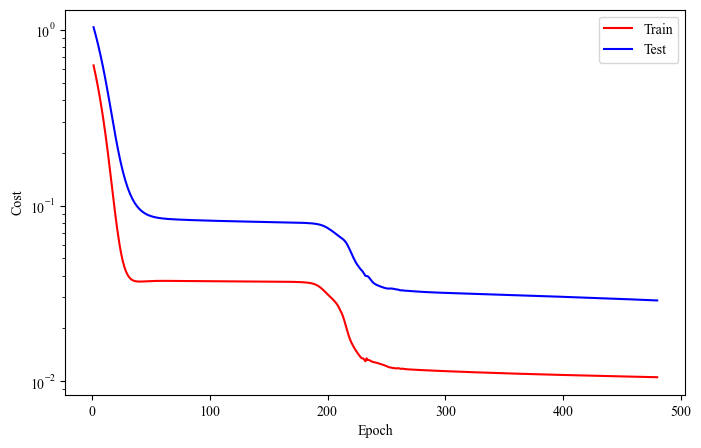

Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   481
Train_cost  = 0.0106 | Test_cost  = 0.0288 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   482
Train_cost  = 0.0106 | Test_cost  = 0.0288 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   483
Train_cost  = 0.0106 | Test_cost  = 0.0288 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   484
Train_cost  = 0.0105 | Test_cost  = 0.0288 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   485
Train_cost  = 0.0105 | Test_cost  = 0.0288 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   486
Train_cost  = 0.0105 | Test_cost  = 0.0287 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   487
Train_cost  = 0.0105 | Test_cost  = 0.0287 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   488
Train_cost  = 0.0105 | Test_cost  = 0.0287 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   489
Train_cost  = 0.0105 | Test_cost  = 0.0287 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   490
Train_cost  = 0.0105 | Test_cost  = 0.0287 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   491
Train_cost  = 0.0105 | Test_cost  = 0.0286 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   492
Train_cost  = 0.0105 | Test_cost  = 0.0286 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   493
Train_cost  = 0.0105 | Test_cost  = 0.0286 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   494
Train_cost  = 0.0105 | Test_cost  = 0.0286 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   495
Train_cost  = 0.0105 | Test_cost  = 0.0285 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   496
Train_cost  = 0.0105 | Test_cost  = 0.0285 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   497
Train_cost  = 0.0105 | Test_cost  = 0.0285 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   498
Train_cost  = 0.0105 | Test_cost  = 0.0285 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   499
Train_cost  = 0.0105 | Test_cost  = 0.0284 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   500
Train_cost  = 0.0105 | Test_cost  = 0.0284 | 


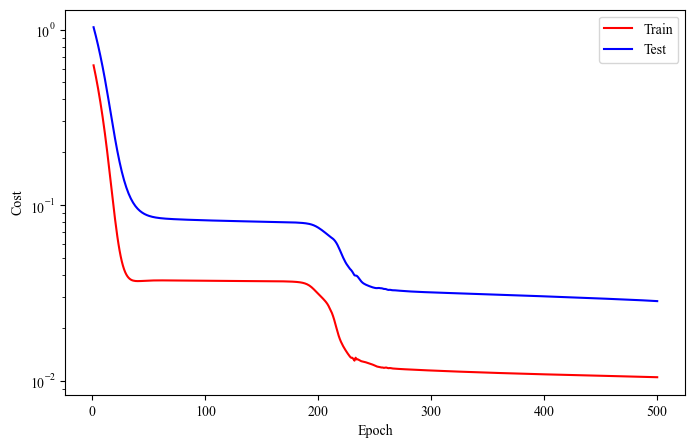

Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   501
Train_cost  = 0.0105 | Test_cost  = 0.0284 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   502
Train_cost  = 0.0105 | Test_cost  = 0.0284 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   503
Train_cost  = 0.0105 | Test_cost  = 0.0283 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   504
Train_cost  = 0.0104 | Test_cost  = 0.0283 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   505
Train_cost  = 0.0104 | Test_cost  = 0.0283 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   506
Train_cost  = 0.0104 | Test_cost  = 0.0282 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   507
Train_cost  = 0.0104 | Test_cost  = 0.0282 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   508
Train_cost  = 0.0104 | Test_cost  = 0.0281 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   509
Train_cost  = 0.0104 | Test_cost  = 0.0281 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   510
Train_cost  = 0.0103 | Test_cost  = 0.0280 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   511
Train_cost  = 0.0103 | Test_cost  = 0.0279 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   512
Train_cost  = 0.0103 | Test_cost  = 0.0277 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   513
Train_cost  = 0.0103 | Test_cost  = 0.0276 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   514
Train_cost  = 0.0103 | Test_cost  = 0.0275 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   515
Train_cost  = 0.0103 | Test_cost  = 0.0275 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   516
Train_cost  = 0.0103 | Test_cost  = 0.0274 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   517
Train_cost  = 0.0103 | Test_cost  = 0.0273 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   518
Train_cost  = 0.0103 | Test_cost  = 0.0273 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   519
Train_cost  = 0.0103 | Test_cost  = 0.0273 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   520
Train_cost  = 0.0103 | Test_cost  = 0.0272 | 


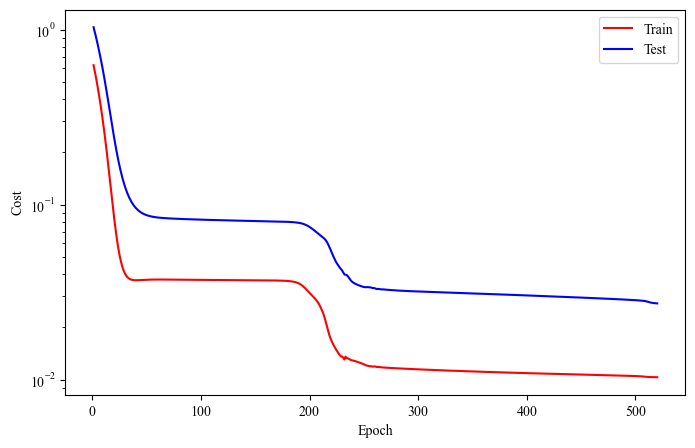

Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   521
Train_cost  = 0.0103 | Test_cost  = 0.0272 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   522
Train_cost  = 0.0103 | Test_cost  = 0.0272 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   523
Train_cost  = 0.0103 | Test_cost  = 0.0272 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   524
Train_cost  = 0.0103 | Test_cost  = 0.0271 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   525
Train_cost  = 0.0103 | Test_cost  = 0.0271 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   526
Train_cost  = 0.0103 | Test_cost  = 0.0271 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   527
Train_cost  = 0.0103 | Test_cost  = 0.0271 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   528
Train_cost  = 0.0103 | Test_cost  = 0.0271 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   529
Train_cost  = 0.0103 | Test_cost  = 0.0271 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   530
Train_cost  = 0.0103 | Test_cost  = 0.0270 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   531
Train_cost  = 0.0103 | Test_cost  = 0.0270 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   532
Train_cost  = 0.0103 | Test_cost  = 0.0270 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   533
Train_cost  = 0.0103 | Test_cost  = 0.0270 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   534
Train_cost  = 0.0103 | Test_cost  = 0.0270 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   535
Train_cost  = 0.0103 | Test_cost  = 0.0270 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   536
Train_cost  = 0.0103 | Test_cost  = 0.0270 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   537
Train_cost  = 0.0103 | Test_cost  = 0.0269 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   538
Train_cost  = 0.0103 | Test_cost  = 0.0269 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   539
Train_cost  = 0.0103 | Test_cost  = 0.0269 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   540
Train_cost  = 0.0103 | Test_cost  = 0.0269 | 


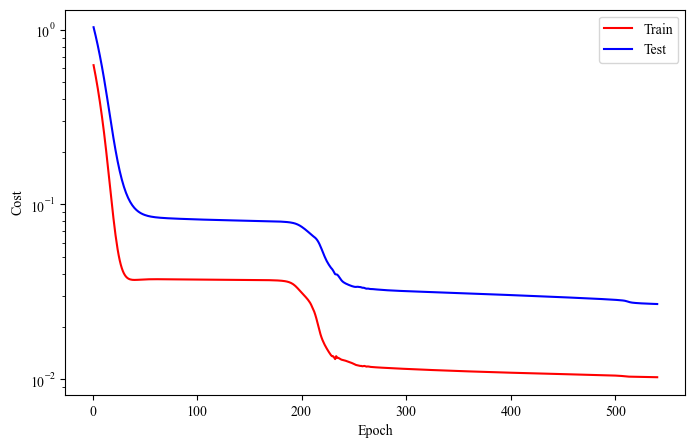

Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   541
Train_cost  = 0.0102 | Test_cost  = 0.0269 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   542
Train_cost  = 0.0102 | Test_cost  = 0.0269 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   543
Train_cost  = 0.0102 | Test_cost  = 0.0269 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   544
Train_cost  = 0.0102 | Test_cost  = 0.0268 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   545
Train_cost  = 0.0102 | Test_cost  = 0.0268 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   546
Train_cost  = 0.0102 | Test_cost  = 0.0268 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   547
Train_cost  = 0.0102 | Test_cost  = 0.0268 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   548
Train_cost  = 0.0102 | Test_cost  = 0.0268 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   549
Train_cost  = 0.0102 | Test_cost  = 0.0268 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   550
Train_cost  = 0.0102 | Test_cost  = 0.0268 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   551
Train_cost  = 0.0102 | Test_cost  = 0.0268 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   552
Train_cost  = 0.0102 | Test_cost  = 0.0267 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   553
Train_cost  = 0.0102 | Test_cost  = 0.0267 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   554
Train_cost  = 0.0102 | Test_cost  = 0.0267 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   555
Train_cost  = 0.0102 | Test_cost  = 0.0267 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   556
Train_cost  = 0.0102 | Test_cost  = 0.0267 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   557
Train_cost  = 0.0102 | Test_cost  = 0.0267 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   558
Train_cost  = 0.0102 | Test_cost  = 0.0267 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   559
Train_cost  = 0.0102 | Test_cost  = 0.0267 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   560
Train_cost  = 0.0102 | Test_cost  = 0.0267 | 


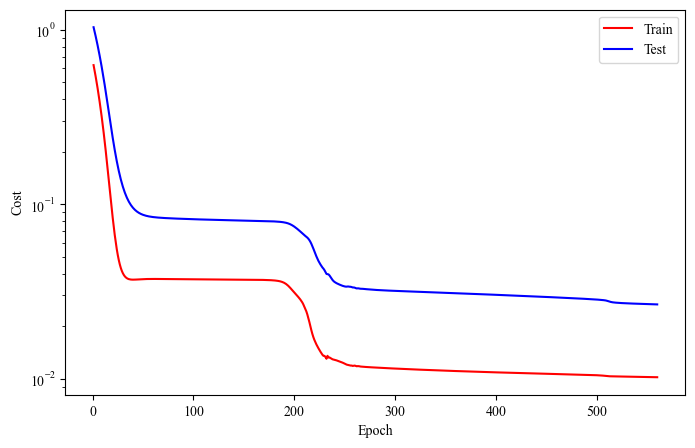

Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   561
Train_cost  = 0.0102 | Test_cost  = 0.0266 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   562
Train_cost  = 0.0102 | Test_cost  = 0.0266 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   563
Train_cost  = 0.0102 | Test_cost  = 0.0266 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   564
Train_cost  = 0.0102 | Test_cost  = 0.0266 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   565
Train_cost  = 0.0102 | Test_cost  = 0.0266 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   566
Train_cost  = 0.0102 | Test_cost  = 0.0266 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   567
Train_cost  = 0.0102 | Test_cost  = 0.0266 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   568
Train_cost  = 0.0102 | Test_cost  = 0.0266 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   569
Train_cost  = 0.0102 | Test_cost  = 0.0266 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   570
Train_cost  = 0.0102 | Test_cost  = 0.0266 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   571
Train_cost  = 0.0102 | Test_cost  = 0.0265 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   572
Train_cost  = 0.0102 | Test_cost  = 0.0265 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   573
Train_cost  = 0.0102 | Test_cost  = 0.0265 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   574
Train_cost  = 0.0102 | Test_cost  = 0.0265 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   575
Train_cost  = 0.0102 | Test_cost  = 0.0265 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   576
Train_cost  = 0.0102 | Test_cost  = 0.0265 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   577
Train_cost  = 0.0102 | Test_cost  = 0.0265 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   578
Train_cost  = 0.0102 | Test_cost  = 0.0265 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   579
Train_cost  = 0.0102 | Test_cost  = 0.0265 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   580
Train_cost  = 0.0102 | Test_cost  = 0.0265 | 


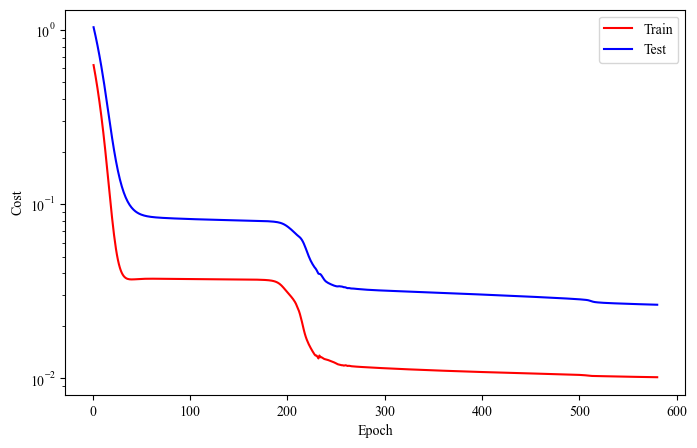

Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   581
Train_cost  = 0.0102 | Test_cost  = 0.0264 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   582
Train_cost  = 0.0102 | Test_cost  = 0.0264 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   583
Train_cost  = 0.0102 | Test_cost  = 0.0264 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   584
Train_cost  = 0.0101 | Test_cost  = 0.0264 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   585
Train_cost  = 0.0101 | Test_cost  = 0.0264 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   586
Train_cost  = 0.0101 | Test_cost  = 0.0264 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   587
Train_cost  = 0.0101 | Test_cost  = 0.0264 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   588
Train_cost  = 0.0101 | Test_cost  = 0.0264 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   589
Train_cost  = 0.0101 | Test_cost  = 0.0264 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   590
Train_cost  = 0.0101 | Test_cost  = 0.0264 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   591
Train_cost  = 0.0101 | Test_cost  = 0.0263 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   592
Train_cost  = 0.0101 | Test_cost  = 0.0263 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   593
Train_cost  = 0.0101 | Test_cost  = 0.0263 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   594
Train_cost  = 0.0101 | Test_cost  = 0.0263 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   595
Train_cost  = 0.0101 | Test_cost  = 0.0263 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   596
Train_cost  = 0.0101 | Test_cost  = 0.0263 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   597
Train_cost  = 0.0101 | Test_cost  = 0.0263 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   598
Train_cost  = 0.0101 | Test_cost  = 0.0263 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   599
Train_cost  = 0.0101 | Test_cost  = 0.0263 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   600
Train_cost  = 0.0101 | Test_cost  = 0.0263 | 


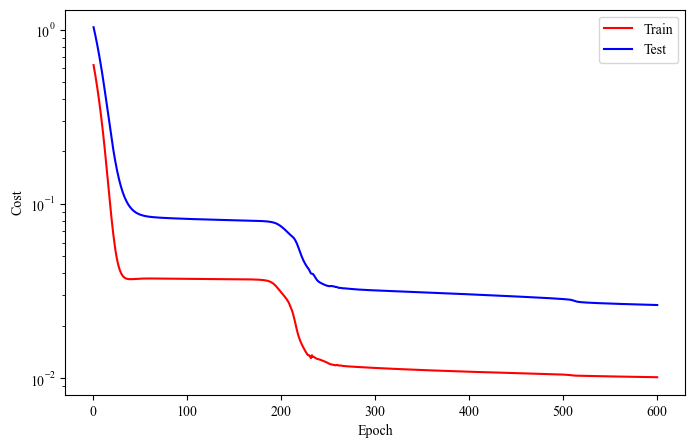

Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   601
Train_cost  = 0.0101 | Test_cost  = 0.0263 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   602
Train_cost  = 0.0101 | Test_cost  = 0.0262 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   603
Train_cost  = 0.0101 | Test_cost  = 0.0262 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   604
Train_cost  = 0.0101 | Test_cost  = 0.0262 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   605
Train_cost  = 0.0101 | Test_cost  = 0.0262 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   606
Train_cost  = 0.0101 | Test_cost  = 0.0262 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   607
Train_cost  = 0.0101 | Test_cost  = 0.0262 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   608
Train_cost  = 0.0101 | Test_cost  = 0.0262 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   609
Train_cost  = 0.0101 | Test_cost  = 0.0262 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   610
Train_cost  = 0.0101 | Test_cost  = 0.0262 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   611
Train_cost  = 0.0101 | Test_cost  = 0.0262 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   612
Train_cost  = 0.0101 | Test_cost  = 0.0262 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   613
Train_cost  = 0.0101 | Test_cost  = 0.0261 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   614
Train_cost  = 0.0101 | Test_cost  = 0.0261 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   615
Train_cost  = 0.0101 | Test_cost  = 0.0261 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   616
Train_cost  = 0.0101 | Test_cost  = 0.0261 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   617
Train_cost  = 0.0101 | Test_cost  = 0.0261 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   618
Train_cost  = 0.0101 | Test_cost  = 0.0261 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   619
Train_cost  = 0.0101 | Test_cost  = 0.0261 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   620
Train_cost  = 0.0101 | Test_cost  = 0.0261 | 


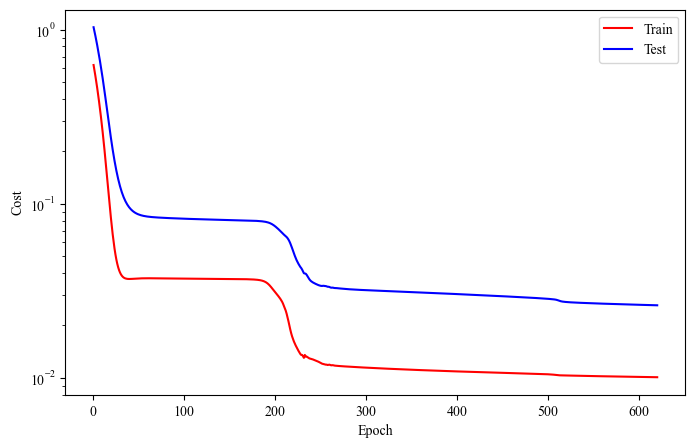

Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   621
Train_cost  = 0.0101 | Test_cost  = 0.0261 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   622
Train_cost  = 0.0101 | Test_cost  = 0.0261 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   623
Train_cost  = 0.0101 | Test_cost  = 0.0261 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   624
Train_cost  = 0.0101 | Test_cost  = 0.0261 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   625
Train_cost  = 0.0101 | Test_cost  = 0.0260 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   626
Train_cost  = 0.0101 | Test_cost  = 0.0260 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   627
Train_cost  = 0.0101 | Test_cost  = 0.0260 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   628
Train_cost  = 0.0101 | Test_cost  = 0.0260 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   629
Train_cost  = 0.0101 | Test_cost  = 0.0260 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   630
Train_cost  = 0.0101 | Test_cost  = 0.0260 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   631
Train_cost  = 0.0101 | Test_cost  = 0.0260 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   632
Train_cost  = 0.0101 | Test_cost  = 0.0260 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   633
Train_cost  = 0.0100 | Test_cost  = 0.0260 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   634
Train_cost  = 0.0100 | Test_cost  = 0.0260 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   635
Train_cost  = 0.0100 | Test_cost  = 0.0260 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   636
Train_cost  = 0.0100 | Test_cost  = 0.0259 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   637
Train_cost  = 0.0100 | Test_cost  = 0.0259 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   638
Train_cost  = 0.0100 | Test_cost  = 0.0259 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   639
Train_cost  = 0.0100 | Test_cost  = 0.0259 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   640
Train_cost  = 0.0100 | Test_cost  = 0.0259 | 


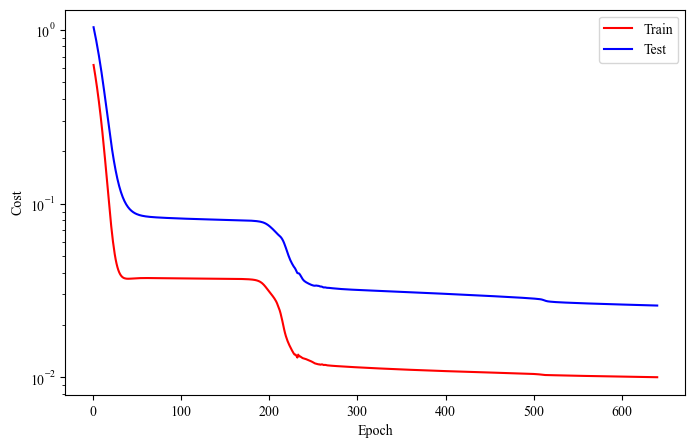

Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   641
Train_cost  = 0.0100 | Test_cost  = 0.0259 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   642
Train_cost  = 0.0100 | Test_cost  = 0.0259 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   643
Train_cost  = 0.0100 | Test_cost  = 0.0259 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   644
Train_cost  = 0.0100 | Test_cost  = 0.0259 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   645
Train_cost  = 0.0100 | Test_cost  = 0.0259 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   646
Train_cost  = 0.0100 | Test_cost  = 0.0259 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   647
Train_cost  = 0.0100 | Test_cost  = 0.0259 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   648
Train_cost  = 0.0100 | Test_cost  = 0.0258 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   649
Train_cost  = 0.0100 | Test_cost  = 0.0258 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   650
Train_cost  = 0.0100 | Test_cost  = 0.0258 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   651
Train_cost  = 0.0100 | Test_cost  = 0.0258 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   652
Train_cost  = 0.0100 | Test_cost  = 0.0258 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   653
Train_cost  = 0.0100 | Test_cost  = 0.0258 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   654
Train_cost  = 0.0100 | Test_cost  = 0.0258 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   655
Train_cost  = 0.0100 | Test_cost  = 0.0258 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   656
Train_cost  = 0.0100 | Test_cost  = 0.0258 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   657
Train_cost  = 0.0100 | Test_cost  = 0.0258 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   658
Train_cost  = 0.0100 | Test_cost  = 0.0258 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   659
Train_cost  = 0.0100 | Test_cost  = 0.0257 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   660
Train_cost  = 0.0100 | Test_cost  = 0.0257 | 


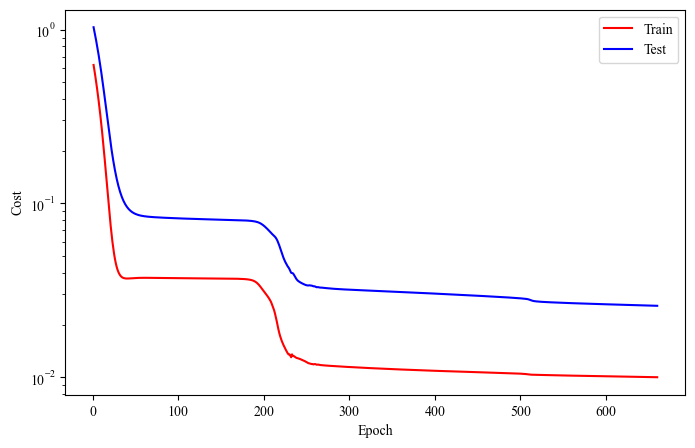

Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   661
Train_cost  = 0.0100 | Test_cost  = 0.0257 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   662
Train_cost  = 0.0100 | Test_cost  = 0.0257 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   663
Train_cost  = 0.0100 | Test_cost  = 0.0257 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   664
Train_cost  = 0.0100 | Test_cost  = 0.0257 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   665
Train_cost  = 0.0100 | Test_cost  = 0.0257 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   666
Train_cost  = 0.0100 | Test_cost  = 0.0257 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   667
Train_cost  = 0.0100 | Test_cost  = 0.0257 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   668
Train_cost  = 0.0100 | Test_cost  = 0.0257 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   669
Train_cost  = 0.0100 | Test_cost  = 0.0257 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   670
Train_cost  = 0.0100 | Test_cost  = 0.0257 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   671
Train_cost  = 0.0100 | Test_cost  = 0.0256 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   672
Train_cost  = 0.0100 | Test_cost  = 0.0256 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   673
Train_cost  = 0.0100 | Test_cost  = 0.0256 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   674
Train_cost  = 0.0100 | Test_cost  = 0.0256 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   675
Train_cost  = 0.0100 | Test_cost  = 0.0256 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   676
Train_cost  = 0.0100 | Test_cost  = 0.0256 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   677
Train_cost  = 0.0100 | Test_cost  = 0.0256 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   678
Train_cost  = 0.0099 | Test_cost  = 0.0256 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   679
Train_cost  = 0.0099 | Test_cost  = 0.0256 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   680
Train_cost  = 0.0099 | Test_cost  = 0.0256 | 


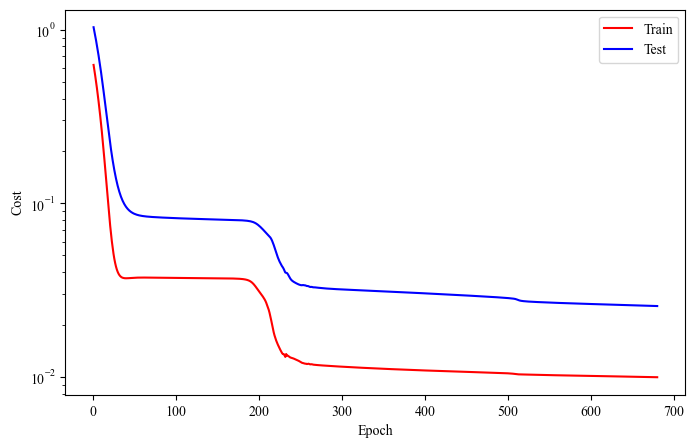

Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   681
Train_cost  = 0.0099 | Test_cost  = 0.0256 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   682
Train_cost  = 0.0099 | Test_cost  = 0.0255 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   683
Train_cost  = 0.0099 | Test_cost  = 0.0255 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   684
Train_cost  = 0.0099 | Test_cost  = 0.0255 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   685
Train_cost  = 0.0099 | Test_cost  = 0.0255 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   686
Train_cost  = 0.0099 | Test_cost  = 0.0255 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   687
Train_cost  = 0.0099 | Test_cost  = 0.0255 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   688
Train_cost  = 0.0099 | Test_cost  = 0.0255 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   689
Train_cost  = 0.0099 | Test_cost  = 0.0255 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   690
Train_cost  = 0.0099 | Test_cost  = 0.0255 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   691
Train_cost  = 0.0099 | Test_cost  = 0.0255 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   692
Train_cost  = 0.0099 | Test_cost  = 0.0255 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   693
Train_cost  = 0.0099 | Test_cost  = 0.0254 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   694
Train_cost  = 0.0099 | Test_cost  = 0.0254 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   695
Train_cost  = 0.0099 | Test_cost  = 0.0254 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   696
Train_cost  = 0.0099 | Test_cost  = 0.0254 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   697
Train_cost  = 0.0099 | Test_cost  = 0.0254 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   698
Train_cost  = 0.0099 | Test_cost  = 0.0254 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   699
Train_cost  = 0.0099 | Test_cost  = 0.0254 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   700
Train_cost  = 0.0099 | Test_cost  = 0.0254 | 


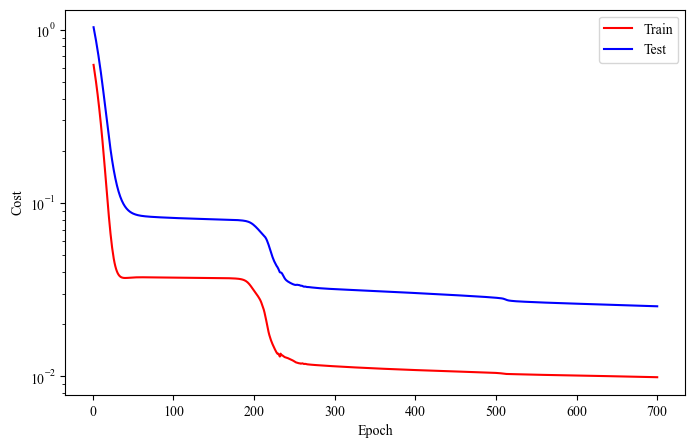

Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   701
Train_cost  = 0.0099 | Test_cost  = 0.0254 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   702
Train_cost  = 0.0099 | Test_cost  = 0.0254 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   703
Train_cost  = 0.0099 | Test_cost  = 0.0253 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   704
Train_cost  = 0.0099 | Test_cost  = 0.0253 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   705
Train_cost  = 0.0099 | Test_cost  = 0.0253 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   706
Train_cost  = 0.0099 | Test_cost  = 0.0253 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   707
Train_cost  = 0.0099 | Test_cost  = 0.0253 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   708
Train_cost  = 0.0099 | Test_cost  = 0.0253 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   709
Train_cost  = 0.0099 | Test_cost  = 0.0253 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   710
Train_cost  = 0.0099 | Test_cost  = 0.0253 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   711
Train_cost  = 0.0099 | Test_cost  = 0.0253 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   712
Train_cost  = 0.0099 | Test_cost  = 0.0252 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   713
Train_cost  = 0.0099 | Test_cost  = 0.0252 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   714
Train_cost  = 0.0099 | Test_cost  = 0.0252 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   715
Train_cost  = 0.0098 | Test_cost  = 0.0252 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   716
Train_cost  = 0.0098 | Test_cost  = 0.0252 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   717
Train_cost  = 0.0098 | Test_cost  = 0.0252 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   718
Train_cost  = 0.0098 | Test_cost  = 0.0252 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   719
Train_cost  = 0.0098 | Test_cost  = 0.0252 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   720
Train_cost  = 0.0098 | Test_cost  = 0.0251 | 


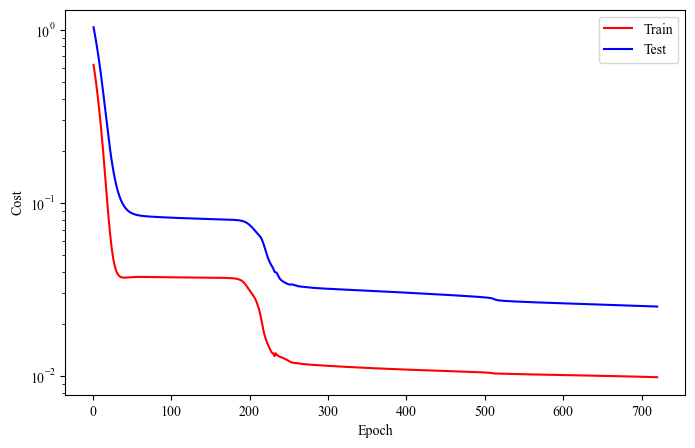

Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   721
Train_cost  = 0.0098 | Test_cost  = 0.0251 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   722
Train_cost  = 0.0098 | Test_cost  = 0.0251 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   723
Train_cost  = 0.0098 | Test_cost  = 0.0251 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   724
Train_cost  = 0.0098 | Test_cost  = 0.0251 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   725
Train_cost  = 0.0098 | Test_cost  = 0.0251 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   726
Train_cost  = 0.0098 | Test_cost  = 0.0251 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   727
Train_cost  = 0.0098 | Test_cost  = 0.0251 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   728
Train_cost  = 0.0098 | Test_cost  = 0.0250 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   729
Train_cost  = 0.0098 | Test_cost  = 0.0250 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   730
Train_cost  = 0.0098 | Test_cost  = 0.0250 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   731
Train_cost  = 0.0098 | Test_cost  = 0.0250 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   732
Train_cost  = 0.0098 | Test_cost  = 0.0250 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   733
Train_cost  = 0.0098 | Test_cost  = 0.0250 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   734
Train_cost  = 0.0098 | Test_cost  = 0.0250 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   735
Train_cost  = 0.0098 | Test_cost  = 0.0249 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   736
Train_cost  = 0.0098 | Test_cost  = 0.0249 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   737
Train_cost  = 0.0098 | Test_cost  = 0.0249 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   738
Train_cost  = 0.0098 | Test_cost  = 0.0249 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   739
Train_cost  = 0.0098 | Test_cost  = 0.0249 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   740
Train_cost  = 0.0098 | Test_cost  = 0.0249 | 


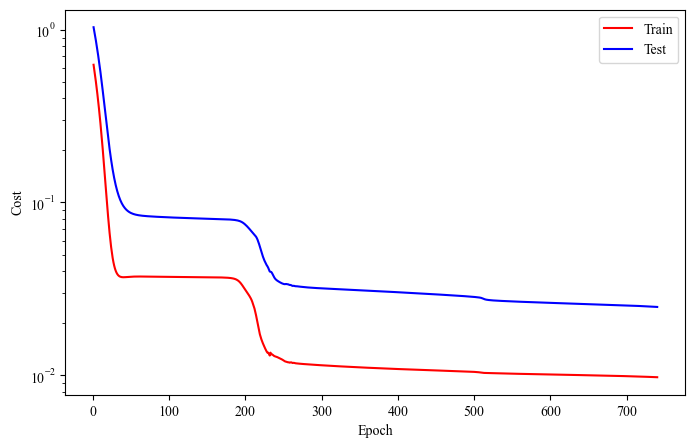

Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   741
Train_cost  = 0.0098 | Test_cost  = 0.0249 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   742
Train_cost  = 0.0097 | Test_cost  = 0.0248 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   743
Train_cost  = 0.0097 | Test_cost  = 0.0248 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   744
Train_cost  = 0.0097 | Test_cost  = 0.0248 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   745
Train_cost  = 0.0097 | Test_cost  = 0.0248 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   746
Train_cost  = 0.0097 | Test_cost  = 0.0248 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   747
Train_cost  = 0.0097 | Test_cost  = 0.0248 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   748
Train_cost  = 0.0097 | Test_cost  = 0.0247 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   749
Train_cost  = 0.0097 | Test_cost  = 0.0247 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   750
Train_cost  = 0.0097 | Test_cost  = 0.0247 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   751
Train_cost  = 0.0097 | Test_cost  = 0.0247 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   752
Train_cost  = 0.0097 | Test_cost  = 0.0247 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   753
Train_cost  = 0.0097 | Test_cost  = 0.0246 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   754
Train_cost  = 0.0097 | Test_cost  = 0.0246 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   755
Train_cost  = 0.0097 | Test_cost  = 0.0246 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   756
Train_cost  = 0.0097 | Test_cost  = 0.0246 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   757
Train_cost  = 0.0097 | Test_cost  = 0.0246 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   758
Train_cost  = 0.0097 | Test_cost  = 0.0246 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   759
Train_cost  = 0.0097 | Test_cost  = 0.0245 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   760
Train_cost  = 0.0097 | Test_cost  = 0.0245 | 


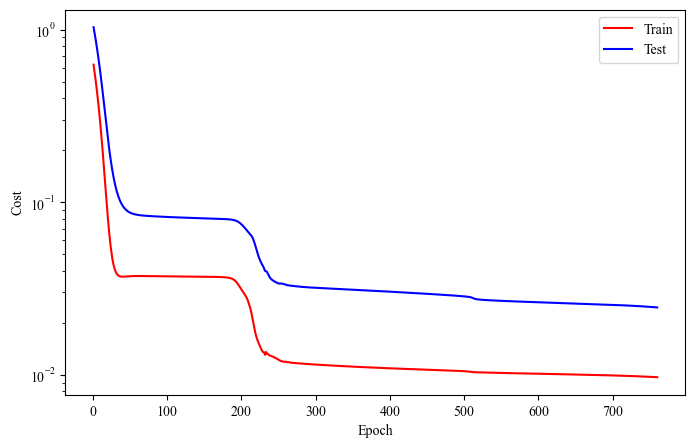

Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   761
Train_cost  = 0.0097 | Test_cost  = 0.0245 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   762
Train_cost  = 0.0096 | Test_cost  = 0.0245 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   763
Train_cost  = 0.0096 | Test_cost  = 0.0244 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   764
Train_cost  = 0.0096 | Test_cost  = 0.0244 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   765
Train_cost  = 0.0096 | Test_cost  = 0.0244 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   766
Train_cost  = 0.0096 | Test_cost  = 0.0244 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   767
Train_cost  = 0.0096 | Test_cost  = 0.0244 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   768
Train_cost  = 0.0096 | Test_cost  = 0.0243 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   769
Train_cost  = 0.0096 | Test_cost  = 0.0243 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   770
Train_cost  = 0.0096 | Test_cost  = 0.0243 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   771
Train_cost  = 0.0096 | Test_cost  = 0.0243 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   772
Train_cost  = 0.0096 | Test_cost  = 0.0242 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   773
Train_cost  = 0.0096 | Test_cost  = 0.0242 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   774
Train_cost  = 0.0096 | Test_cost  = 0.0242 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   775
Train_cost  = 0.0096 | Test_cost  = 0.0242 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   776
Train_cost  = 0.0096 | Test_cost  = 0.0241 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   777
Train_cost  = 0.0096 | Test_cost  = 0.0241 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   778
Train_cost  = 0.0095 | Test_cost  = 0.0241 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   779
Train_cost  = 0.0095 | Test_cost  = 0.0241 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   780
Train_cost  = 0.0095 | Test_cost  = 0.0240 | 


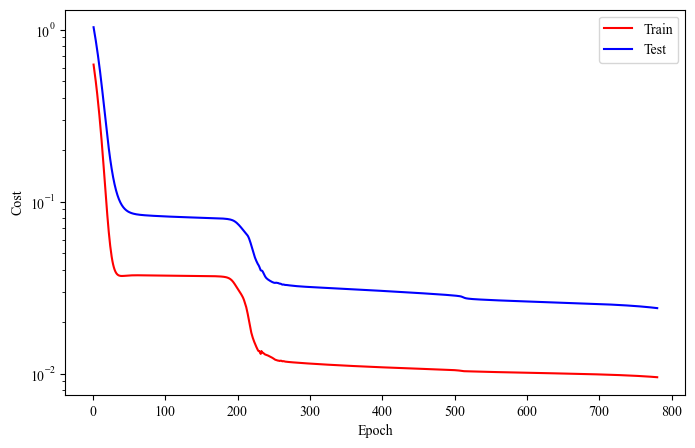

Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   781
Train_cost  = 0.0095 | Test_cost  = 0.0240 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   782
Train_cost  = 0.0095 | Test_cost  = 0.0240 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   783
Train_cost  = 0.0095 | Test_cost  = 0.0239 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   784
Train_cost  = 0.0095 | Test_cost  = 0.0239 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   785
Train_cost  = 0.0095 | Test_cost  = 0.0239 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   786
Train_cost  = 0.0095 | Test_cost  = 0.0238 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   787
Train_cost  = 0.0095 | Test_cost  = 0.0238 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   788
Train_cost  = 0.0095 | Test_cost  = 0.0238 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   789
Train_cost  = 0.0095 | Test_cost  = 0.0238 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   790
Train_cost  = 0.0094 | Test_cost  = 0.0237 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   791
Train_cost  = 0.0094 | Test_cost  = 0.0237 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   792
Train_cost  = 0.0094 | Test_cost  = 0.0236 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   793
Train_cost  = 0.0094 | Test_cost  = 0.0236 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   794
Train_cost  = 0.0094 | Test_cost  = 0.0236 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   795
Train_cost  = 0.0094 | Test_cost  = 0.0235 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   796
Train_cost  = 0.0094 | Test_cost  = 0.0235 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   797
Train_cost  = 0.0094 | Test_cost  = 0.0235 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   798
Train_cost  = 0.0094 | Test_cost  = 0.0234 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   799
Train_cost  = 0.0094 | Test_cost  = 0.0234 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   800
Train_cost  = 0.0093 | Test_cost  = 0.0234 | 


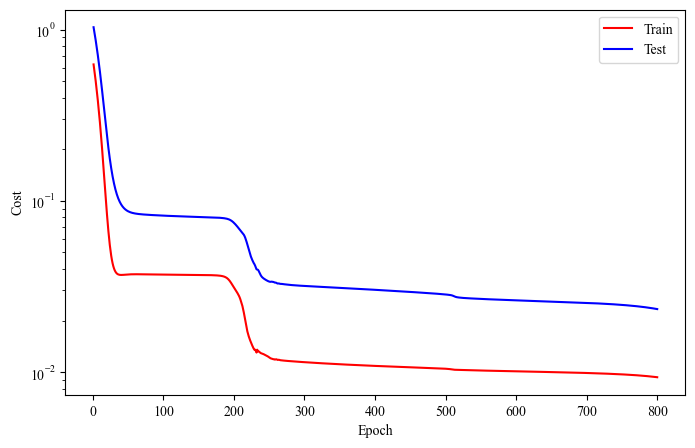

Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   801
Train_cost  = 0.0093 | Test_cost  = 0.0233 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   802
Train_cost  = 0.0093 | Test_cost  = 0.0233 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   803
Train_cost  = 0.0093 | Test_cost  = 0.0232 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   804
Train_cost  = 0.0093 | Test_cost  = 0.0232 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   805
Train_cost  = 0.0093 | Test_cost  = 0.0231 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   806
Train_cost  = 0.0093 | Test_cost  = 0.0231 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   807
Train_cost  = 0.0093 | Test_cost  = 0.0231 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   808
Train_cost  = 0.0093 | Test_cost  = 0.0230 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   809
Train_cost  = 0.0092 | Test_cost  = 0.0230 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   810
Train_cost  = 0.0092 | Test_cost  = 0.0229 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   811
Train_cost  = 0.0092 | Test_cost  = 0.0229 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   812
Train_cost  = 0.0092 | Test_cost  = 0.0228 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   813
Train_cost  = 0.0092 | Test_cost  = 0.0228 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   814
Train_cost  = 0.0092 | Test_cost  = 0.0228 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   815
Train_cost  = 0.0092 | Test_cost  = 0.0227 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   816
Train_cost  = 0.0092 | Test_cost  = 0.0227 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   817
Train_cost  = 0.0091 | Test_cost  = 0.0226 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   818
Train_cost  = 0.0091 | Test_cost  = 0.0226 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   819
Train_cost  = 0.0091 | Test_cost  = 0.0225 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   820
Train_cost  = 0.0091 | Test_cost  = 0.0225 | 


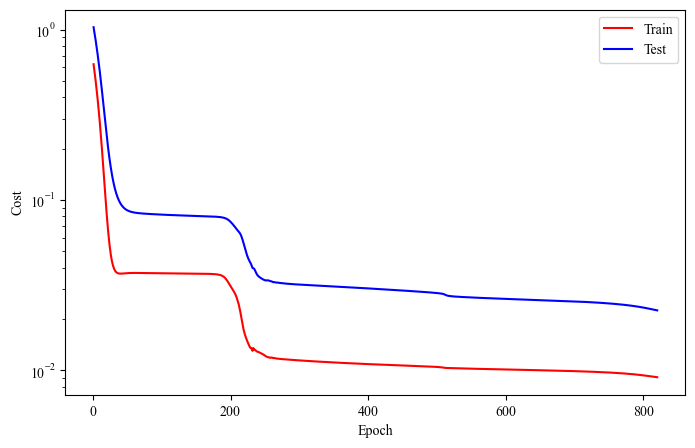

Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   821
Train_cost  = 0.0091 | Test_cost  = 0.0224 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   822
Train_cost  = 0.0091 | Test_cost  = 0.0224 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   823
Train_cost  = 0.0091 | Test_cost  = 0.0224 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   824
Train_cost  = 0.0091 | Test_cost  = 0.0223 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   825
Train_cost  = 0.0091 | Test_cost  = 0.0223 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   826
Train_cost  = 0.0090 | Test_cost  = 0.0222 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   827
Train_cost  = 0.0090 | Test_cost  = 0.0222 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   828
Train_cost  = 0.0090 | Test_cost  = 0.0221 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   829
Train_cost  = 0.0090 | Test_cost  = 0.0221 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   830
Train_cost  = 0.0090 | Test_cost  = 0.0221 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   831
Train_cost  = 0.0090 | Test_cost  = 0.0220 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   832
Train_cost  = 0.0090 | Test_cost  = 0.0220 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   833
Train_cost  = 0.0090 | Test_cost  = 0.0219 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   834
Train_cost  = 0.0089 | Test_cost  = 0.0219 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   835
Train_cost  = 0.0089 | Test_cost  = 0.0219 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   836
Train_cost  = 0.0089 | Test_cost  = 0.0218 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   837
Train_cost  = 0.0089 | Test_cost  = 0.0218 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   838
Train_cost  = 0.0089 | Test_cost  = 0.0218 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   839
Train_cost  = 0.0089 | Test_cost  = 0.0217 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   840
Train_cost  = 0.0089 | Test_cost  = 0.0217 | 


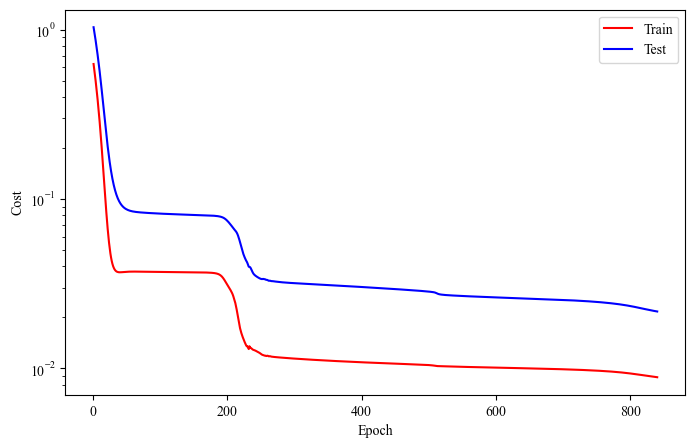

Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   841
Train_cost  = 0.0089 | Test_cost  = 0.0217 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   842
Train_cost  = 0.0089 | Test_cost  = 0.0216 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   843
Train_cost  = 0.0088 | Test_cost  = 0.0216 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   844
Train_cost  = 0.0088 | Test_cost  = 0.0216 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   845
Train_cost  = 0.0088 | Test_cost  = 0.0215 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   846
Train_cost  = 0.0088 | Test_cost  = 0.0215 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   847
Train_cost  = 0.0088 | Test_cost  = 0.0215 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   848
Train_cost  = 0.0088 | Test_cost  = 0.0214 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   849
Train_cost  = 0.0088 | Test_cost  = 0.0214 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   850
Train_cost  = 0.0088 | Test_cost  = 0.0214 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   851
Train_cost  = 0.0088 | Test_cost  = 0.0214 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   852
Train_cost  = 0.0087 | Test_cost  = 0.0213 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   853
Train_cost  = 0.0087 | Test_cost  = 0.0213 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   854
Train_cost  = 0.0087 | Test_cost  = 0.0213 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   855
Train_cost  = 0.0087 | Test_cost  = 0.0213 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   856
Train_cost  = 0.0087 | Test_cost  = 0.0212 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   857
Train_cost  = 0.0087 | Test_cost  = 0.0212 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   858
Train_cost  = 0.0087 | Test_cost  = 0.0212 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   859
Train_cost  = 0.0087 | Test_cost  = 0.0212 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   860
Train_cost  = 0.0087 | Test_cost  = 0.0212 | 


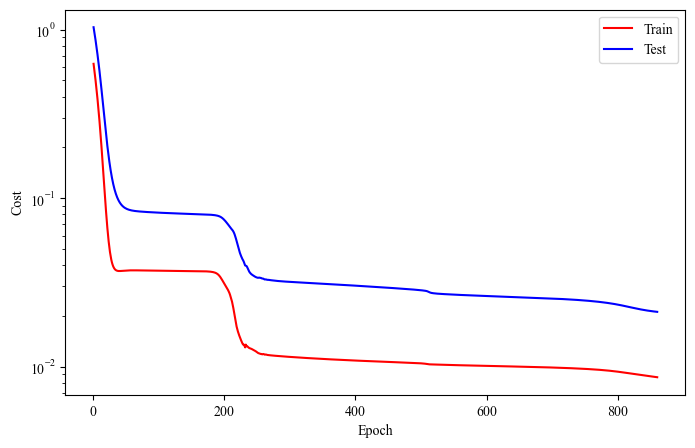

Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   861
Train_cost  = 0.0087 | Test_cost  = 0.0211 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   862
Train_cost  = 0.0086 | Test_cost  = 0.0211 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   863
Train_cost  = 0.0086 | Test_cost  = 0.0211 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   864
Train_cost  = 0.0086 | Test_cost  = 0.0211 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   865
Train_cost  = 0.0086 | Test_cost  = 0.0211 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   866
Train_cost  = 0.0086 | Test_cost  = 0.0210 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   867
Train_cost  = 0.0086 | Test_cost  = 0.0210 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   868
Train_cost  = 0.0086 | Test_cost  = 0.0210 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   869
Train_cost  = 0.0086 | Test_cost  = 0.0210 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   870
Train_cost  = 0.0086 | Test_cost  = 0.0210 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   871
Train_cost  = 0.0086 | Test_cost  = 0.0210 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   872
Train_cost  = 0.0085 | Test_cost  = 0.0209 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   873
Train_cost  = 0.0085 | Test_cost  = 0.0209 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   874
Train_cost  = 0.0085 | Test_cost  = 0.0209 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   875
Train_cost  = 0.0085 | Test_cost  = 0.0209 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   876
Train_cost  = 0.0085 | Test_cost  = 0.0209 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   877
Train_cost  = 0.0085 | Test_cost  = 0.0209 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   878
Train_cost  = 0.0085 | Test_cost  = 0.0209 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   879
Train_cost  = 0.0085 | Test_cost  = 0.0208 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   880
Train_cost  = 0.0085 | Test_cost  = 0.0208 | 


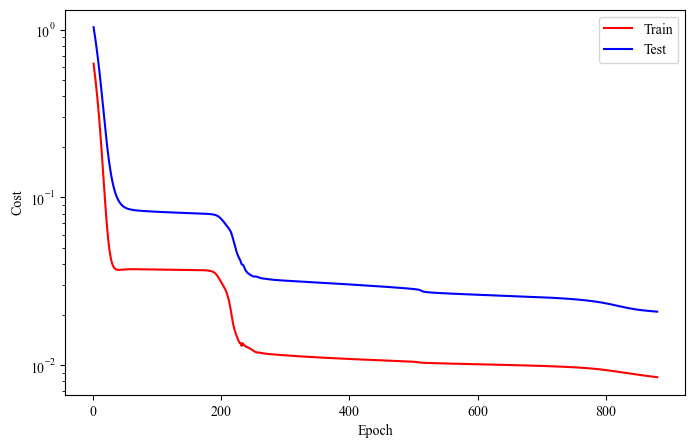

Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   881
Train_cost  = 0.0085 | Test_cost  = 0.0208 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   882
Train_cost  = 0.0085 | Test_cost  = 0.0208 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   883
Train_cost  = 0.0084 | Test_cost  = 0.0208 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   884
Train_cost  = 0.0084 | Test_cost  = 0.0208 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   885
Train_cost  = 0.0084 | Test_cost  = 0.0208 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   886
Train_cost  = 0.0084 | Test_cost  = 0.0207 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   887
Train_cost  = 0.0084 | Test_cost  = 0.0207 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   888
Train_cost  = 0.0084 | Test_cost  = 0.0207 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   889
Train_cost  = 0.0084 | Test_cost  = 0.0207 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   890
Train_cost  = 0.0084 | Test_cost  = 0.0207 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   891
Train_cost  = 0.0084 | Test_cost  = 0.0207 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   892
Train_cost  = 0.0084 | Test_cost  = 0.0207 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   893
Train_cost  = 0.0084 | Test_cost  = 0.0207 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   894
Train_cost  = 0.0083 | Test_cost  = 0.0206 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   895
Train_cost  = 0.0083 | Test_cost  = 0.0206 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   896
Train_cost  = 0.0083 | Test_cost  = 0.0206 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   897
Train_cost  = 0.0083 | Test_cost  = 0.0206 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   898
Train_cost  = 0.0083 | Test_cost  = 0.0206 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   899
Train_cost  = 0.0083 | Test_cost  = 0.0206 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   900
Train_cost  = 0.0083 | Test_cost  = 0.0206 | 


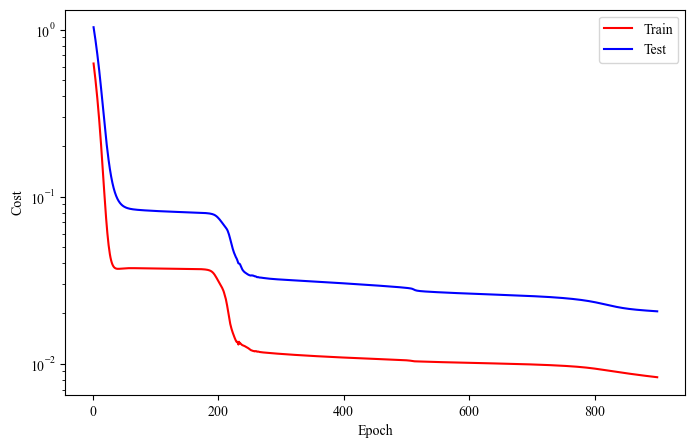

Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   901
Train_cost  = 0.0083 | Test_cost  = 0.0206 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   902
Train_cost  = 0.0083 | Test_cost  = 0.0205 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   903
Train_cost  = 0.0083 | Test_cost  = 0.0205 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   904
Train_cost  = 0.0083 | Test_cost  = 0.0205 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   905
Train_cost  = 0.0083 | Test_cost  = 0.0205 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   906
Train_cost  = 0.0082 | Test_cost  = 0.0205 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   907
Train_cost  = 0.0082 | Test_cost  = 0.0205 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   908
Train_cost  = 0.0082 | Test_cost  = 0.0205 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   909
Train_cost  = 0.0082 | Test_cost  = 0.0205 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   910
Train_cost  = 0.0082 | Test_cost  = 0.0205 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   911
Train_cost  = 0.0082 | Test_cost  = 0.0204 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   912
Train_cost  = 0.0082 | Test_cost  = 0.0204 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   913
Train_cost  = 0.0082 | Test_cost  = 0.0204 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   914
Train_cost  = 0.0082 | Test_cost  = 0.0204 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   915
Train_cost  = 0.0082 | Test_cost  = 0.0204 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   916
Train_cost  = 0.0082 | Test_cost  = 0.0204 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   917
Train_cost  = 0.0082 | Test_cost  = 0.0204 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   918
Train_cost  = 0.0082 | Test_cost  = 0.0204 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   919
Train_cost  = 0.0081 | Test_cost  = 0.0204 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   920
Train_cost  = 0.0081 | Test_cost  = 0.0204 | 


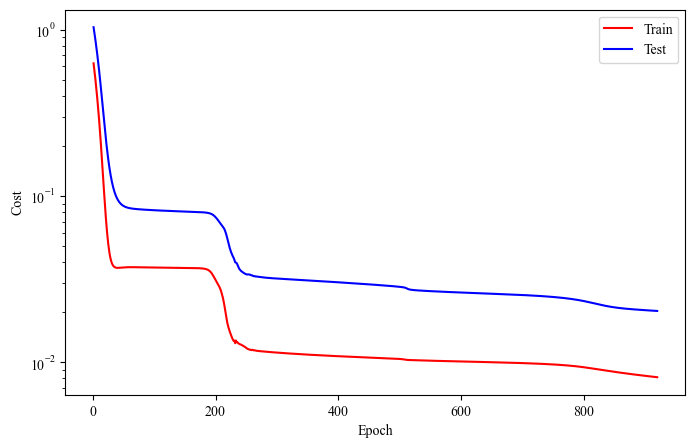

Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   921
Train_cost  = 0.0081 | Test_cost  = 0.0203 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   922
Train_cost  = 0.0081 | Test_cost  = 0.0203 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   923
Train_cost  = 0.0081 | Test_cost  = 0.0203 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   924
Train_cost  = 0.0081 | Test_cost  = 0.0203 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   925
Train_cost  = 0.0081 | Test_cost  = 0.0203 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   926
Train_cost  = 0.0081 | Test_cost  = 0.0203 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   927
Train_cost  = 0.0081 | Test_cost  = 0.0203 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   928
Train_cost  = 0.0081 | Test_cost  = 0.0203 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   929
Train_cost  = 0.0081 | Test_cost  = 0.0203 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   930
Train_cost  = 0.0081 | Test_cost  = 0.0203 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   931
Train_cost  = 0.0081 | Test_cost  = 0.0202 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   932
Train_cost  = 0.0080 | Test_cost  = 0.0202 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   933
Train_cost  = 0.0080 | Test_cost  = 0.0202 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   934
Train_cost  = 0.0080 | Test_cost  = 0.0202 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   935
Train_cost  = 0.0080 | Test_cost  = 0.0202 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   936
Train_cost  = 0.0080 | Test_cost  = 0.0202 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   937
Train_cost  = 0.0080 | Test_cost  = 0.0202 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   938
Train_cost  = 0.0080 | Test_cost  = 0.0202 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   939
Train_cost  = 0.0080 | Test_cost  = 0.0202 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   940
Train_cost  = 0.0080 | Test_cost  = 0.0202 | 


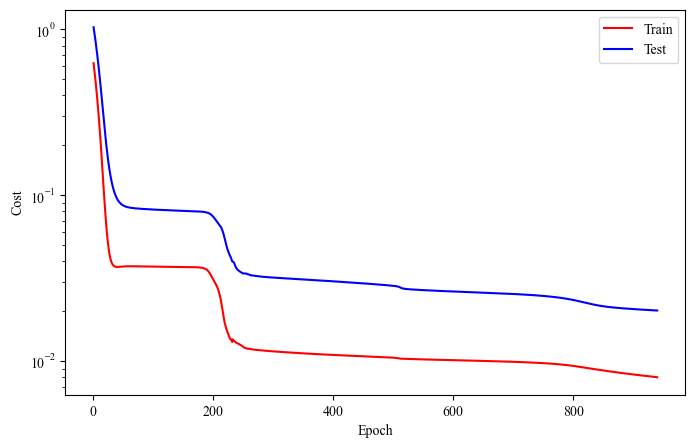

Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   941
Train_cost  = 0.0080 | Test_cost  = 0.0202 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   942
Train_cost  = 0.0080 | Test_cost  = 0.0201 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   943
Train_cost  = 0.0080 | Test_cost  = 0.0201 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   944
Train_cost  = 0.0080 | Test_cost  = 0.0201 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   945
Train_cost  = 0.0079 | Test_cost  = 0.0201 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   946
Train_cost  = 0.0079 | Test_cost  = 0.0201 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   947
Train_cost  = 0.0079 | Test_cost  = 0.0201 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   948
Train_cost  = 0.0079 | Test_cost  = 0.0201 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   949
Train_cost  = 0.0079 | Test_cost  = 0.0201 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   950
Train_cost  = 0.0079 | Test_cost  = 0.0201 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   951
Train_cost  = 0.0079 | Test_cost  = 0.0201 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   952
Train_cost  = 0.0079 | Test_cost  = 0.0201 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   953
Train_cost  = 0.0079 | Test_cost  = 0.0201 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   954
Train_cost  = 0.0079 | Test_cost  = 0.0201 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   955
Train_cost  = 0.0079 | Test_cost  = 0.0200 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   956
Train_cost  = 0.0079 | Test_cost  = 0.0200 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   957
Train_cost  = 0.0079 | Test_cost  = 0.0200 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   958
Train_cost  = 0.0079 | Test_cost  = 0.0200 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   959
Train_cost  = 0.0078 | Test_cost  = 0.0200 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   960
Train_cost  = 0.0078 | Test_cost  = 0.0200 | 


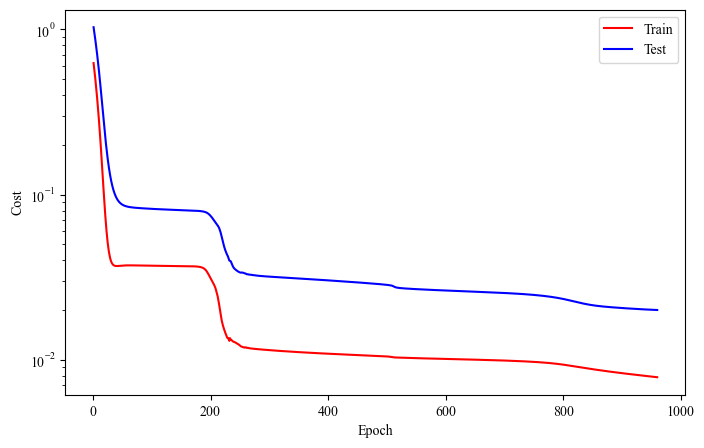

Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   961
Train_cost  = 0.0078 | Test_cost  = 0.0200 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   962
Train_cost  = 0.0078 | Test_cost  = 0.0200 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   963
Train_cost  = 0.0078 | Test_cost  = 0.0200 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   964
Train_cost  = 0.0078 | Test_cost  = 0.0200 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   965
Train_cost  = 0.0078 | Test_cost  = 0.0200 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   966
Train_cost  = 0.0078 | Test_cost  = 0.0200 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   967
Train_cost  = 0.0078 | Test_cost  = 0.0200 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   968
Train_cost  = 0.0078 | Test_cost  = 0.0200 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   969
Train_cost  = 0.0078 | Test_cost  = 0.0200 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   970
Train_cost  = 0.0078 | Test_cost  = 0.0200 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   971
Train_cost  = 0.0078 | Test_cost  = 0.0200 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   972
Train_cost  = 0.0078 | Test_cost  = 0.0199 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   973
Train_cost  = 0.0078 | Test_cost  = 0.0199 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   974
Train_cost  = 0.0077 | Test_cost  = 0.0199 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   975
Train_cost  = 0.0077 | Test_cost  = 0.0199 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   976
Train_cost  = 0.0077 | Test_cost  = 0.0199 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   977
Train_cost  = 0.0077 | Test_cost  = 0.0199 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   978
Train_cost  = 0.0077 | Test_cost  = 0.0199 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   979
Train_cost  = 0.0077 | Test_cost  = 0.0199 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   980
Train_cost  = 0.0077 | Test_cost  = 0.0199 | 


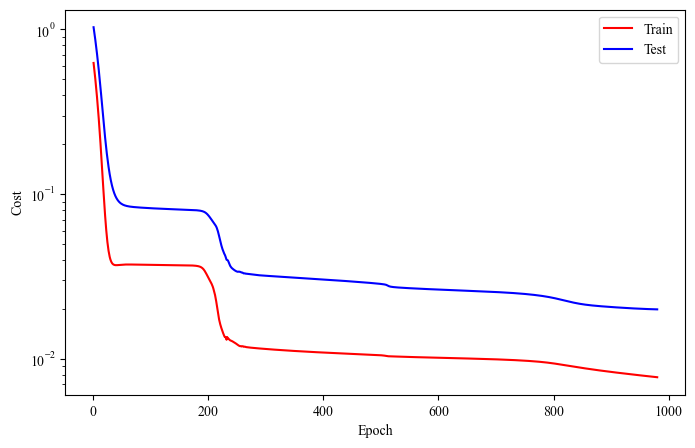

Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   981
Train_cost  = 0.0077 | Test_cost  = 0.0199 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   982
Train_cost  = 0.0077 | Test_cost  = 0.0199 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   983
Train_cost  = 0.0077 | Test_cost  = 0.0199 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   984
Train_cost  = 0.0077 | Test_cost  = 0.0199 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   985
Train_cost  = 0.0077 | Test_cost  = 0.0199 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   986
Train_cost  = 0.0077 | Test_cost  = 0.0199 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   987
Train_cost  = 0.0077 | Test_cost  = 0.0199 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   988
Train_cost  = 0.0077 | Test_cost  = 0.0199 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   989
Train_cost  = 0.0076 | Test_cost  = 0.0199 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   990
Train_cost  = 0.0076 | Test_cost  = 0.0199 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   991
Train_cost  = 0.0076 | Test_cost  = 0.0199 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   992
Train_cost  = 0.0076 | Test_cost  = 0.0199 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   993
Train_cost  = 0.0076 | Test_cost  = 0.0199 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   994
Train_cost  = 0.0076 | Test_cost  = 0.0199 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   995
Train_cost  = 0.0076 | Test_cost  = 0.0199 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   996
Train_cost  = 0.0076 | Test_cost  = 0.0199 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   997
Train_cost  = 0.0076 | Test_cost  = 0.0199 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   998
Train_cost  = 0.0076 | Test_cost  = 0.0199 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   999
Train_cost  = 0.0076 | Test_cost  = 0.0199 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch  1000
Train_cost  = 0.0076 | Test_cost  = 0.0198 | 


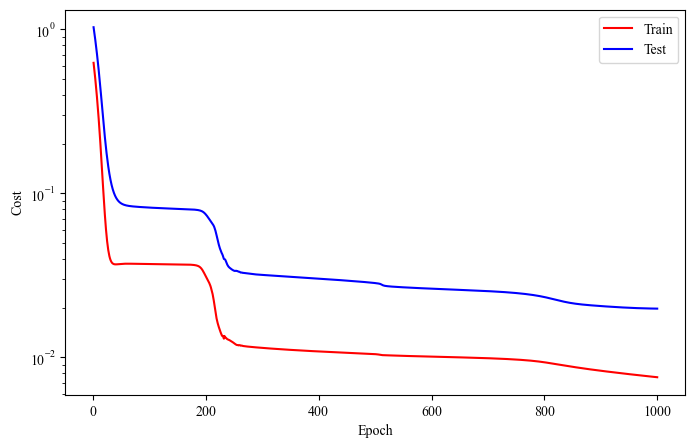

Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch  1001
Train_cost  = 0.0076 | Test_cost  = 0.0198 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch  1002
Train_cost  = 0.0076 | Test_cost  = 0.0198 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch  1003
Train_cost  = 0.0076 | Test_cost  = 0.0198 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch  1004
Train_cost  = 0.0076 | Test_cost  = 0.0198 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch  1005
Train_cost  = 0.0075 | Test_cost  = 0.0198 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch  1006
Train_cost  = 0.0075 | Test_cost  = 0.0198 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch  1007
Train_cost  = 0.0075 | Test_cost  = 0.0198 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch  1008
Train_cost  = 0.0075 | Test_cost  = 0.0198 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch  1009
Train_cost  = 0.0075 | Test_cost  = 0.0198 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch  1010
Train_cost  = 0.0075 | Test_cost  = 0.0198 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch  1011
Train_cost  = 0.0075 | Test_cost  = 0.0198 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch  1012
Train_cost  = 0.0075 | Test_cost  = 0.0198 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch  1013
Train_cost  = 0.0075 | Test_cost  = 0.0198 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch  1014
Train_cost  = 0.0075 | Test_cost  = 0.0198 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch  1015
Train_cost  = 0.0075 | Test_cost  = 0.0198 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch  1016
Train_cost  = 0.0075 | Test_cost  = 0.0198 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch  1017
Train_cost  = 0.0075 | Test_cost  = 0.0198 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch  1018
Train_cost  = 0.0075 | Test_cost  = 0.0198 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch  1019
Train_cost  = 0.0075 | Test_cost  = 0.0198 | 


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch  1020
Train_cost  = 0.0075 | Test_cost  = 0.0198 | 


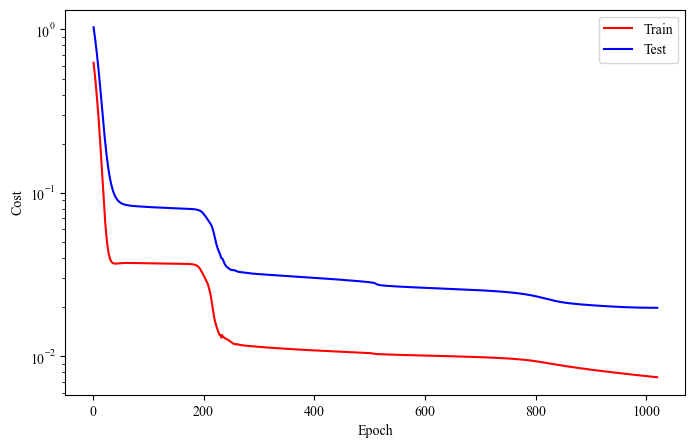

Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch  1021
Train_cost  = 0.0075 | Test_cost  = 0.0198 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0198


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch  1022
Train_cost  = 0.0074 | Test_cost  = 0.0198 | 
==> EarlyStop patience =  2 | Best test_cost: 0.0198


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch  1023
Train_cost  = 0.0074 | Test_cost  = 0.0198 | 
==> EarlyStop patience =  3 | Best test_cost: 0.0198


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch  1024
Train_cost  = 0.0074 | Test_cost  = 0.0198 | 
==> EarlyStop patience =  4 | Best test_cost: 0.0198


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch  1025
Train_cost  = 0.0074 | Test_cost  = 0.0198 | 
==> EarlyStop patience =  5 | Best test_cost: 0.0198
==> Execute Early Stopping at epoch: 1025 | Best test_cost: 0.0198
==> Best model is saved at model/LSTM


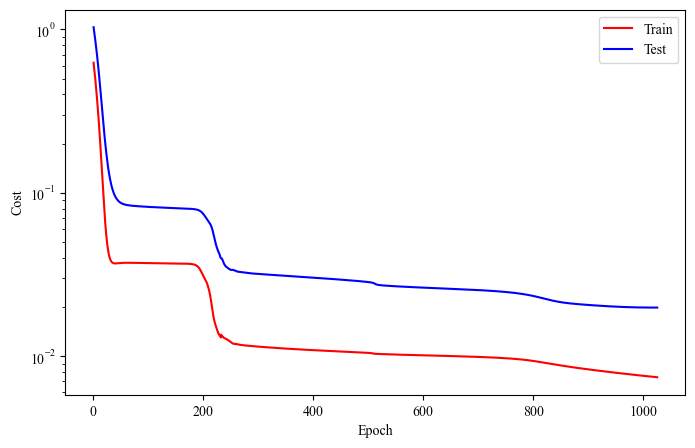

In [146]:
while True: 
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)


    #logging
    callback.log(train_cost, test_cost)

    #checkpoint 
    callback.save_checkpoint()

    callback.cost_runtime_plotting()

    #early stopping 
    if callback.early_stopping(model, monitor="test_cost"):
        # Modifikasi plotting menjadi hitam putih
        callback.plot_cost()
        break

In [147]:
from utils import data4pred, pred4pred 

In [148]:
train_forecast_set = TimeSeriesDataset(ts_train, "GWH_JUAL_FILTERED", 1)
trainforecastloader = DataLoader(train_forecast_set)

test_forecast_set = TimeSeriesDataset(ts_test, "GWH_JUAL_FILTERED", 1)
testforecastloader = DataLoader(test_forecast_set)

(N, S, F): (66, 1, 2)
Note: last 0 data excluded

(N, S, F): (16, 1, 2)
Note: last 0 data excluded



In [149]:
import torch
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def mean_absolute_percentage_error(targets, preds):
    return np.mean(np.abs((targets - preds) / targets)) * 100

def symmetric_mean_absolute_percentage_error(targets, preds):
    return np.mean(2.0 * np.abs(preds - targets) / (np.abs(targets) + np.abs(preds))) * 100



Text(0.5, 1.0, 'Test')

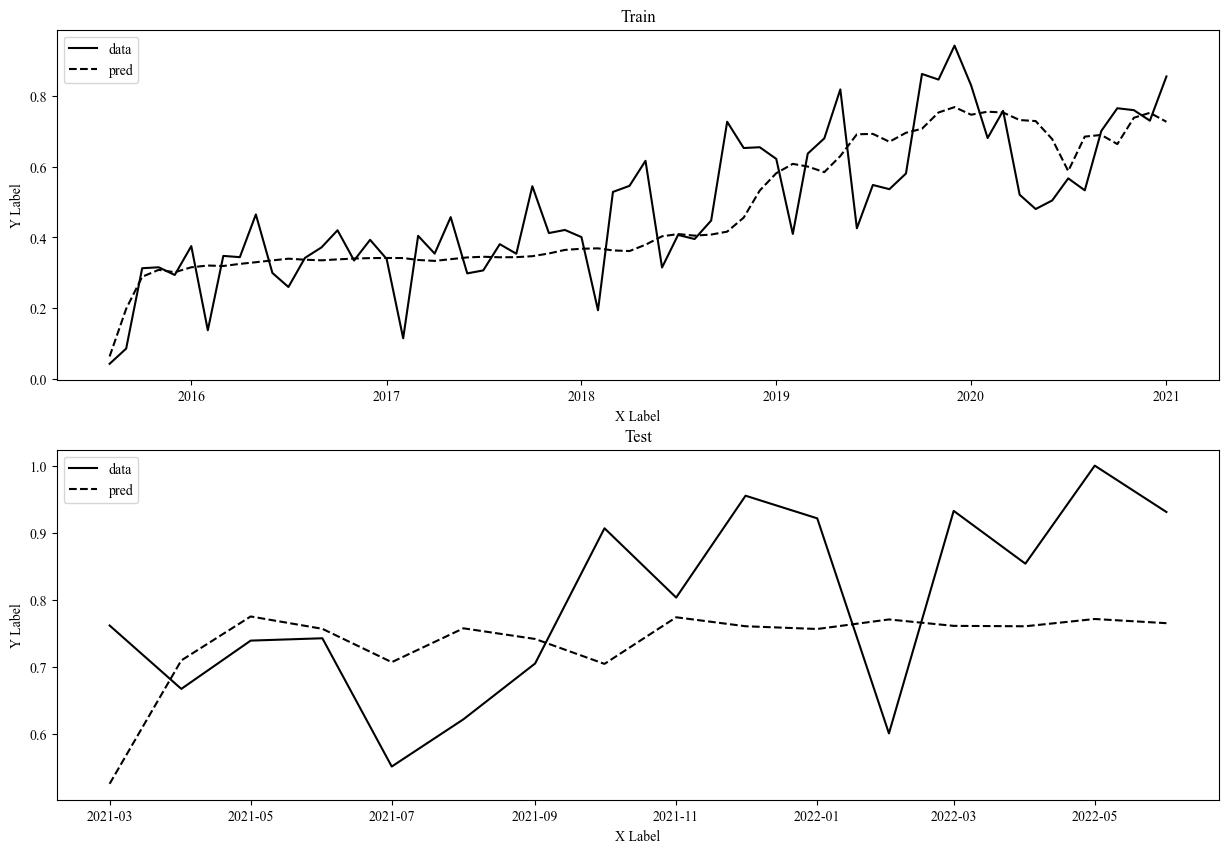

In [150]:
plt.figure(figsize=(15, 10))

plt.subplot(211)
data4pred(model, train_forecast_set, trainforecastloader, device)
plt.title("Train")

plt.subplot(212)
data4pred(model, test_forecast_set, testforecastloader, device)
plt.title("Test")

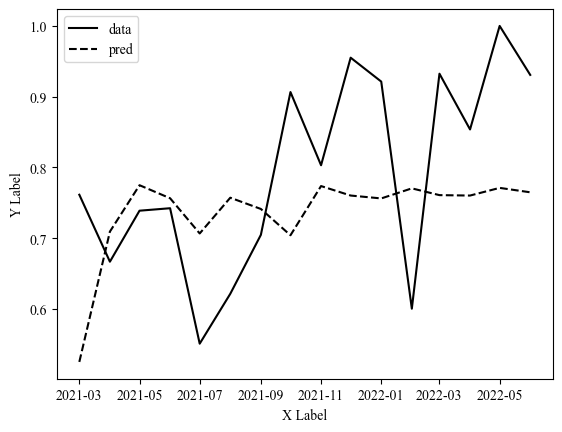

In [151]:
test_preds, test_targets = data4pred(model, test_forecast_set, testforecastloader, device)
test_targets_array = np.array(test_targets).reshape(-1, 1)
test_preds_array = np.array(test_preds).reshape(-1, 1)

# Fit MinMaxScaler dan langsung inverse_transform
scaler = MinMaxScaler()
test_targets_original = scaler.fit_transform(test_targets_array).flatten()
test_preds_original = scaler.fit_transform(test_preds_array).flatten()

In [152]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def mean_absolute_percentage_error(targets, preds):
    targets = np.array(targets)
    preds = np.array(preds)
    return np.mean(np.abs((targets - preds) / targets)) * 100

def symmetric_mean_absolute_percentage_error(targets, preds):
    targets = np.array(targets)
    preds = np.array(preds)
    return np.mean(2.0 * np.abs(preds - targets) / (np.abs(targets) + np.abs(preds))) * 100

# Contoh penggunaan evaluasi metrik untuk data uji
test_mae = mean_absolute_error(test_targets, test_preds)
test_mse = mean_squared_error(test_targets, test_preds)
test_r2 = r2_score(test_targets, test_preds)
test_mape = mean_absolute_percentage_error(test_targets, test_preds)
test_smape = symmetric_mean_absolute_percentage_error(test_targets, test_preds)

print("Metrics for Test Data:")
print(f"MAE  : {test_mae:.4f}")
print(f"MSE  : {test_mse:.4f}")
print(f"R²   : {test_r2:.4f}")
print(f"MAPE : {test_mape:.4f}%")
print(f"SMAPE: {test_smape:.4f}%")

Metrics for Test Data:
MAE  : 0.1299
MSE  : 0.0223
R²   : -0.2066
MAPE : 16.3832%
SMAPE: 17.0219%


In [153]:
import importlib
import utils

# Memuat ulang modul utils setelah perubahan
importlib.reload(utils)
from utils import data4pred, pred4pred, predict_long_term 

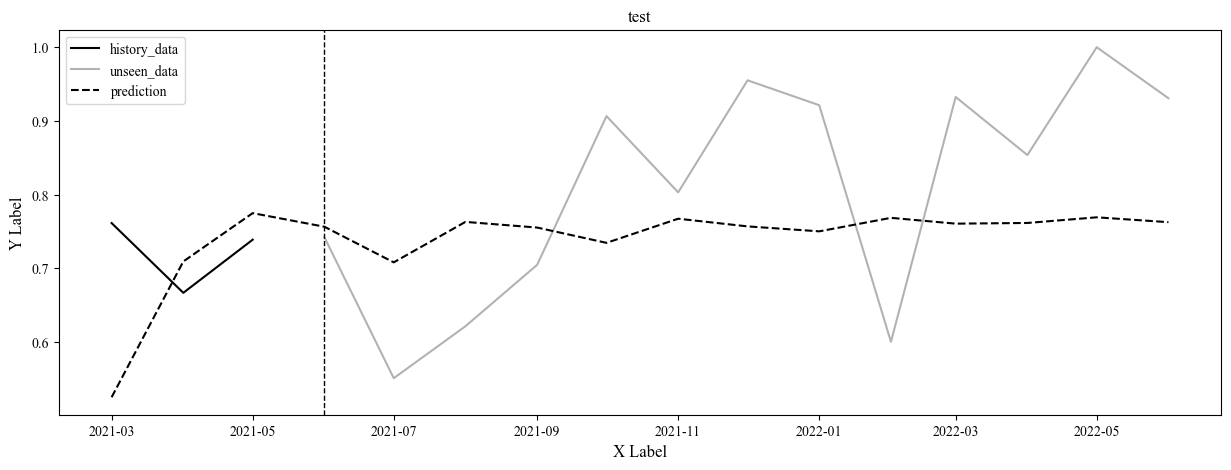

In [154]:
plt.figure(figsize=(15,5))
pred4pred(model, test_forecast_set, testforecastloader, device)
plt.title("test");

IndexError: index 21 is out of bounds for axis 0 with size 16

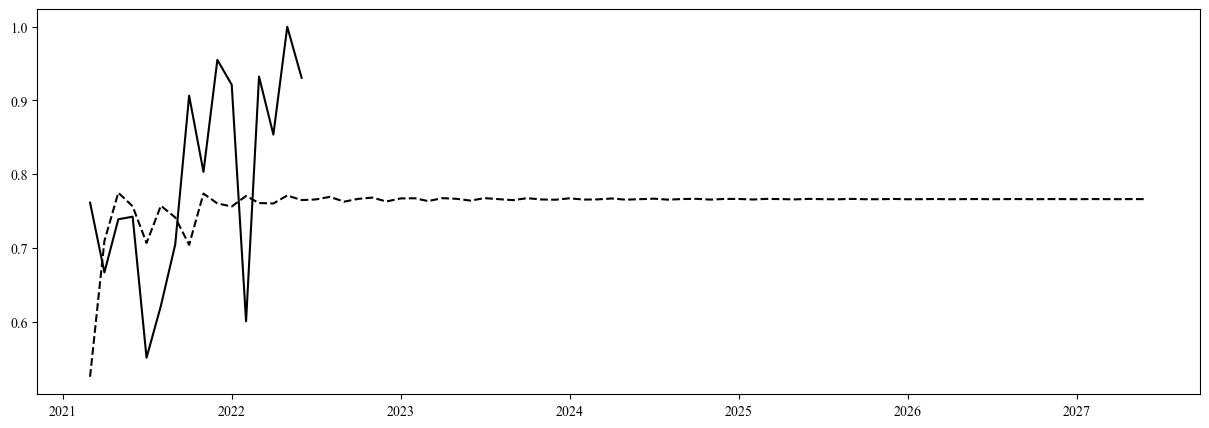

In [155]:
plt.figure(figsize=(15,5))
predict_long_term(model, test_forecast_set, testforecastloader, device)
plt.title("60 Month ahead");